In [27]:
import pandas as pd
import itertools
import os
from tqdm import tqdm
from collections import defaultdict, Counter
import pickle
import random
from scipy.stats import entropy
import matplotlib.pyplot as plt

In [2]:
# Let grey is represented by 0, yellow by 1 and green by 2
# what could be possible input info of 5 letter word in wordle
allPatterns = list(itertools.product([0,1,2], repeat=5))
print(len(allPatterns))
# Total 3 power 5 that is 243 possible combination

243


In [3]:
#  Extracting all and curated word list from data folder
# with open(r'words.txt', encoding='utf-8') as f:
#     rawwordlelist = f.read()
# rawwordlelist = rawwordlelist.split(",")
# allWordList = []
# for word in rawwordlelist:
#     word = word.strip('"')
#     allWordList.append(word)
# print(len(allWordList))

allWordList = list(pd.read_csv('./data/processed/valid_guesses.csv')['word'])
curatedWordList = list(pd.read_csv('./data/processed/valid_solutions.csv')['word'])
allWordList += curatedWordList
print("all valid guess words Len",len(allWordList))
print("curated word list Len:", len(curatedWordList))

all valid guess words Len 12972
curated word list Len: 2315


In [4]:
# First 2315 words of our list are most frequent wordle answers. so lets extract it too.
# curatedWordList = allWordList[:2315]
# print(len(curatedWordList))

In [5]:
# Sanity check whether all words are of 5 length or not
errorMsg = 'All words are not of 5 letter each'
assert len({len(x) for x in allWordList}) == 1 and len(allWordList[0]) == 5, errorMsg

In [6]:
def convertWordToPattern(guessWord, realAnswer):
    """
    lets suppose if ans is midst and we guessed digit then we return (1, 2, 0, 1, 2)
    """
    pattern = [0, 0, 0 ,0 ,0]
    for i, x in enumerate(guessWord):
        pattern[i] = int(x in realAnswer)
    for i, (x1, x2) in enumerate(zip(guessWord, realAnswer)):
        if x1 == x2:
            pattern[i] = 2
    
    return tuple(pattern)

# lets test it
print(convertWordToPattern('digit', 'midst'))
    

(1, 2, 0, 1, 2)


In [7]:
def createPatternMap(wordList):
    """
    For every word in the wordlist with every possible pattern information we get from wordle game, 
    lets create a list of possible set of words.
    """
    wordPatternMap = defaultdict(lambda: defaultdict(set))
    for word in tqdm(wordList):
        for realAnswer in wordList:
            pattern = convertWordToPattern(word, wordList)
            wordPatternMap[word][pattern].add(realAnswer)
    return dict(wordPatternMap)


In [8]:
if 'wordPatternMap.p' not in os.listdir('./data/processed'):
#     Lets cache this patterns map so that we dont need to create it everytime
    wordPatternMap = createPatternMap(curatedWordList)
    pickle.dump(wordPatternMap, open('./data/processed/wordPatternMap.p', 'wb+'))
else:
    # loading patterns map from the cache file
    wordPatternMap = pickle.load(open('./data/processed/wordPatternMap.p', 'rb'))

In [9]:
def calculateEntropies(possibleWords, wordPatternMap):
#     wordList,
    """
    Calculating the entropy for every word in our words list , taking into account the remaining possible words
    """
    entropiesMap = {}
    for word in tqdm(possibleWords):
        counts = []
        for pattern in allPatterns:
            matches = wordPatternMap[word][tuple(pattern)]
            matches = matches.intersection(possibleWords)
            counts.append(len(matches))
        entropiesMap[word] = entropy(counts)
    return entropiesMap

In [10]:
# Lets begin a trial
# Lets play wordle with nytimes by giving guess word and its pattern output as result

# Assumption: If there is duplicate letter, pattern will show 1 for duplicate letter which
# is in wrong position and not 0

def playNyTimesWordleWithUserInput():
#     realAnswer = random.choice(curatedWordList)
#     print("====RealAnswer to reach is ", realAnswer)
    possibleWords = set(curatedWordList)

    for i in range(6):
    #     print("====possiblewordss", possibleWords)
        entropies = calculateEntropies( possibleWords, wordPatternMap)
        print("set of possible words includes like:")
        print([sample_word[0] for sample_word in sorted(entropies.items(), key=lambda sample_word: -sample_word[1])[:10]])

    #   Pick max entropy word
        guessWord = random.choice([x[0] for x in sorted(entropies.items(), key=lambda x: -x[1])[:10]])
        print('Our suggestion for guess based on Entropy: ', guessWord)
        
        print("=====Now tell which Word you want to Put in Wordle as your guess:  eg: midst")
        guessWord = input()
        print('===Now Enter the pattern info return by wordle: eg: 01221 where 0=grey,1=yellow, 2=green color')
        guessWordPatternOutput = tuple(map(int, tuple(input())))

#         guessWordPatternOutput = [0, 0, 0, 0, 0]
#         for i, l1 in enumerate(guessWord):
#             guessWordPatternOutput[i] = int(l1 in realAnswer)

#         for i, (l1, l2) in enumerate(zip(guessWord, realAnswer)):
#             if l1 == l2:
#                 guessWordPatternOutput[i] = 2

        print('you guessed: \"', guessWord, '\"wordle pattern you provided:', guessWordPatternOutput)
        if guessWordPatternOutput == (2,2,2,2,2):
            print(f'WIN! in {i+1} guesses')
            print()
            print()
            print()
            break
    #     print("wordPatternMap", wordPatternMap[guessWord])
        words = wordPatternMap[guessWord][tuple(guessWordPatternOutput)]
    #     print("====words", words)
        possibleWords = possibleWords.intersection(words)
playNyTimesWordleWithUserInput()
    

100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4000.22it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
=====Now tell which Word you want to Put in Wordle as your guess:  eg: midst
trace
===Now Enter the pattern info return by wordle: eg: 01221 where 0=grey,1=yellow, 2=green color
00110
you guessed: " trace "wordle pattern you provided: (0, 0, 1, 1, 0)


100%|██████████████████████████████████████████| 32/32 [00:00<00:00, 676.06it/s]


set of possible words includes like:
['canal', 'cabal', 'cacao', 'cabin', 'bacon', 'manic', 'cavil', 'canon', 'china', 'vocal']
Our suggestion for guess based on Entropy:  canal
=====Now tell which Word you want to Put in Wordle as your guess:  eg: midst
cacao
===Now Enter the pattern info return by wordle: eg: 01221 where 0=grey,1=yellow, 2=green color
22110
you guessed: " cacao "wordle pattern you provided: (2, 2, 1, 1, 0)


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 2521.70it/s]


set of possible words includes like:
['candy', 'cabin', 'canny', 'caddy', 'cabby', 'cavil', 'caulk']
Our suggestion for guess based on Entropy:  caddy
=====Now tell which Word you want to Put in Wordle as your guess:  eg: midst
caddy
===Now Enter the pattern info return by wordle: eg: 01221 where 0=grey,1=yellow, 2=green color
22002
you guessed: " caddy "wordle pattern you provided: (2, 2, 0, 0, 2)


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 339.34it/s]


set of possible words includes like:
['cabby', 'canny']
Our suggestion for guess based on Entropy:  canny
=====Now tell which Word you want to Put in Wordle as your guess:  eg: midst
canny
===Now Enter the pattern info return by wordle: eg: 01221 where 0=grey,1=yellow, 2=green color
22222
you guessed: " canny "wordle pattern you provided: (2, 2, 2, 2, 2)
WIN! in 4 guesses





In [17]:
# Statistical Analysis for number of trails
countSum = 0
totalTrial = 0
guessCountToWin = list()
for noOfTrial in range(200):
    sm = 0
    realAnswer = random.choice(curatedWordList)
    print("====RealAnswer to reach is ", realAnswer)
    possibleWords = set(curatedWordList)

    for _ in range(10):
        entropies = calculateEntropies( possibleWords, wordPatternMap)
        print("set of possible words includes like:")
        print([sample_word[0] for sample_word in sorted(entropies.items(), key=lambda sample_word: -sample_word[1])[:10]])

    #   Pick max entropy word
        guessWord = random.choice([x[0] for x in sorted(entropies.items(), key=lambda x: -x[1])[:10]])
        print('Our suggestion for guess based on Entropy: ', guessWord)
        
        sm += 1
        guessWordPatternOutput = [0, 0, 0, 0, 0]
        for i, l1 in enumerate(guessWord):
            guessWordPatternOutput[i] = int(l1 in realAnswer)

        for i, (l1, l2) in enumerate(zip(guessWord, realAnswer)):
            if l1 == l2:
                guessWordPatternOutput[i] = 2

        print('guessWordPatternOutput:', guessWordPatternOutput)
        if guessWord == realAnswer:
            guessCountToWin.append(sm)
            countSum += sm
            print('You Won! :',  len(guessCountToWin), ' times')
            print()
            print()
            print()
            break
    #     print("wordPatternMap", wordPatternMap[guessWord])
        words = wordPatternMap[guessWord][tuple(guessWordPatternOutput)]
    #     print("====words", words)
        possibleWords = possibleWords.intersection(words)


====RealAnswer to reach is  fetch


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4287.88it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 110/110 [00:00<00:00, 5682.71it/s]


set of possible words includes like:
['hotel', 'filet', 'betel', 'depot', 'dwelt', 'debit', 'towel', 'tepid', 'plied', 'dowel']
Our suggestion for guess based on Entropy:  towel
guessWordPatternOutput: [1, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 17/17 [00:00<00:00, 5588.46it/s]


set of possible words includes like:
['edict', 'depth', 'deity', 'befit', 'debit', 'fetid', 'evict', 'eight', 'fetch', 'hefty']
Our suggestion for guess based on Entropy:  deity
guessWordPatternOutput: [0, 2, 0, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4583.94it/s]


set of possible words includes like:
['fetch']
Our suggestion for guess based on Entropy:  fetch
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 1  times



====RealAnswer to reach is  giver


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 3877.22it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 1, 1, 0, 1]


100%|█████████████████████████████████████████| 34/34 [00:00<00:00, 2115.63it/s]


set of possible words includes like:
['rivet', 'finer', 'diner', 'liner', 'ripen', 'miner', 'infer', 'liver', 'diver', 'filer']
Our suggestion for guess based on Entropy:  ripen
guessWordPatternOutput: [1, 2, 0, 2, 0]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 1881.78it/s]


set of possible words includes like:
['diver', 'filer', 'giver', 'liver', 'cider', 'tiger', 'wider', 'fiber', 'fixer', 'timer']
Our suggestion for guess based on Entropy:  diver
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 598.46it/s]


set of possible words includes like:
['liver', 'giver']
Our suggestion for guess based on Entropy:  giver
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 2  times



====RealAnswer to reach is  poser


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 2767.06it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [1, 0, 0, 1, 1]


100%|█████████████████████████████████████████| 16/16 [00:00<00:00, 6864.65it/s]


set of possible words includes like:
['reset', 'poser', 'wrest', 'crest', 'wiser', 'riser', 'press', 'loser', 'usher', 'cress']
Our suggestion for guess based on Entropy:  riser
guessWordPatternOutput: [1, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6533.18it/s]


set of possible words includes like:
['poser', 'loser']
Our suggestion for guess based on Entropy:  loser
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5029.14it/s]


set of possible words includes like:
['poser']
Our suggestion for guess based on Entropy:  poser
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 3  times



====RealAnswer to reach is  olive


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4118.76it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 87/87 [00:00<00:00, 6977.27it/s]


set of possible words includes like:
['guile', 'glide', 'lunge', 'clone', 'binge', 'ounce', 'bilge', 'boule', 'hinge', 'globe']
Our suggestion for guess based on Entropy:  bilge
guessWordPatternOutput: [0, 1, 1, 0, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7197.43it/s]


set of possible words includes like:
['elide', 'exile', 'while', 'olive']
Our suggestion for guess based on Entropy:  elide
guessWordPatternOutput: [1, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4951.95it/s]


set of possible words includes like:
['olive']
Our suggestion for guess based on Entropy:  olive
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 4  times



====RealAnswer to reach is  finch


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 3449.24it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 107/107 [00:00<00:00, 7151.36it/s]


set of possible words includes like:
['pilot', 'pinto', 'tonic', 'unlit', 'minty', 'until', 'optic', 'filth', 'limit', 'light']
Our suggestion for guess based on Entropy:  pilot
guessWordPatternOutput: [0, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 16/16 [00:00<00:00, 6334.61it/s]


set of possible words includes like:
['windy', 'dingy', 'giddy', 'finch', 'dizzy', 'biddy', 'winch', 'kinky', 'cinch', 'ninny']
Our suggestion for guess based on Entropy:  finch
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 5  times



====RealAnswer to reach is  stoke


100%|█████████████████████████████████████| 2315/2315 [00:01<00:00, 2027.70it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [2, 0, 0, 0, 2]


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 957.23it/s]


set of possible words includes like:
['stole', 'spite', 'smile', 'slime', 'slope', 'smote', 'smite', 'slice', 'stoke', 'stove']
Our suggestion for guess based on Entropy:  slope
guessWordPatternOutput: [2, 0, 2, 0, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 3885.05it/s]


set of possible words includes like:
['stove', 'stoke', 'smoke', 'smote', 'shove']
Our suggestion for guess based on Entropy:  smote
guessWordPatternOutput: [2, 0, 2, 1, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 2018.43it/s]


set of possible words includes like:
['stoke', 'stove']
Our suggestion for guess based on Entropy:  stoke
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 6  times



====RealAnswer to reach is  amber


100%|█████████████████████████████████████| 2315/2315 [00:01<00:00, 1685.35it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 1, 0, 1]


100%|█████████████████████████████████████████| 61/61 [00:00<00:00, 5841.25it/s]


set of possible words includes like:
['amber', 'cream', 'ramen', 'cedar', 'debar', 'anger', 'recap', 'dream', 'bread', 'caper']
Our suggestion for guess based on Entropy:  anger
guessWordPatternOutput: [2, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7300.79it/s]


set of possible words includes like:
['amber', 'aider']
Our suggestion for guess based on Entropy:  amber
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 7  times



====RealAnswer to reach is  heron


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4337.94it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 0, 1, 1]


100%|███████████████████████████████████████| 118/118 [00:00<00:00, 6746.66it/s]


set of possible words includes like:
['diner', 'cider', 'rider', 'idler', 'decor', 'older', 'liner', 'filer', 'diver', 'flier']
Our suggestion for guess based on Entropy:  older
guessWordPatternOutput: [1, 0, 0, 1, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6132.02it/s]


set of possible words includes like:
['heron']
Our suggestion for guess based on Entropy:  heron
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 8  times



====RealAnswer to reach is  shied


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4331.66it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 2, 1, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 5067.62it/s]


set of possible words includes like:
['spied', 'spiel', 'shied']
Our suggestion for guess based on Entropy:  spiel
guessWordPatternOutput: [2, 0, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5210.32it/s]


set of possible words includes like:
['shied']
Our suggestion for guess based on Entropy:  shied
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 9  times



====RealAnswer to reach is  sower


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 3719.12it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 1, 0, 1, 0]


100%|█████████████████████████████████████████| 59/59 [00:00<00:00, 6932.15it/s]


set of possible words includes like:
['spire', 'spine', 'snipe', 'siren', 'shire', 'shine', 'swine', 'spice', 'risen', 'spore']
Our suggestion for guess based on Entropy:  shire
guessWordPatternOutput: [2, 0, 0, 1, 1]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 7566.39it/s]


set of possible words includes like:
['super', 'sober', 'surer', 'sower', 'screw', 'sneer']
Our suggestion for guess based on Entropy:  screw
guessWordPatternOutput: [2, 0, 1, 2, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5817.34it/s]


set of possible words includes like:
['sower']
Our suggestion for guess based on Entropy:  sower
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 10  times



====RealAnswer to reach is  whose


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4075.63it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 0, 0, 2, 2]


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2509.38it/s]


set of possible words includes like:
['loose', 'chose', 'close', 'house', 'those', 'louse', 'noose', 'goose', 'moose', 'mouse']
Our suggestion for guess based on Entropy:  chose
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6620.84it/s]


set of possible words includes like:
['those', 'whose']
Our suggestion for guess based on Entropy:  whose
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 11  times



====RealAnswer to reach is  olive


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 3620.97it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 2, 0, 0, 2]


100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 6798.75it/s]


set of possible words includes like:
['globe', 'glove', 'elope', 'bloke', 'olive', 'elude', 'clove', 'glide', 'clone', 'elide']
Our suggestion for guess based on Entropy:  clone
guessWordPatternOutput: [0, 2, 1, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5159.05it/s]


set of possible words includes like:
['olive']
Our suggestion for guess based on Entropy:  olive
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 12  times



====RealAnswer to reach is  youth


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 3951.01it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 104/104 [00:00<00:00, 6668.41it/s]


set of possible words includes like:
['donut', 'count', 'doing', 'doubt', 'mount', 'point', 'dingo', 'month', 'moult', 'login']
Our suggestion for guess based on Entropy:  doubt
guessWordPatternOutput: [0, 2, 2, 0, 1]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7256.58it/s]


set of possible words includes like:
['touch', 'youth', 'mouth', 'pouty', 'tough']
Our suggestion for guess based on Entropy:  tough
guessWordPatternOutput: [1, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 3318.28it/s]


set of possible words includes like:
['mouth', 'youth']
Our suggestion for guess based on Entropy:  mouth
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4882.78it/s]


set of possible words includes like:
['youth']
Our suggestion for guess based on Entropy:  youth
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 13  times



====RealAnswer to reach is  oaken


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 3790.16it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 1, 1, 0, 1]


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 4973.97it/s]


set of possible words includes like:
['glean', 'clean', 'navel', 'vegan', 'laden', 'alien', 'taken', 'ocean', 'haven', 'panel']
Our suggestion for guess based on Entropy:  glean
guessWordPatternOutput: [0, 0, 1, 1, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 5766.16it/s]


set of possible words includes like:
['taken', 'oaken', 'eaten', 'waxen', 'haven']
Our suggestion for guess based on Entropy:  waxen
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7407.16it/s]


set of possible words includes like:
['taken', 'oaken', 'eaten', 'haven']
Our suggestion for guess based on Entropy:  haven
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 4580.60it/s]


set of possible words includes like:
['oaken', 'taken', 'eaten']
Our suggestion for guess based on Entropy:  taken
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2325.00it/s]


set of possible words includes like:
['oaken']
Our suggestion for guess based on Entropy:  oaken
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 14  times



====RealAnswer to reach is  lapse


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4319.98it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [1, 1, 1, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 6978.88it/s]


set of possible words includes like:
['false', 'lapse', 'aisle']
Our suggestion for guess based on Entropy:  false
guessWordPatternOutput: [0, 2, 1, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6026.30it/s]


set of possible words includes like:
['lapse']
Our suggestion for guess based on Entropy:  lapse
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 15  times



====RealAnswer to reach is  scold


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 2638.45it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 80/80 [00:00<00:00, 2417.88it/s]


set of possible words includes like:
['stunk', 'stony', 'stock', 'spunk', 'shunt', 'sloth', 'stuck', 'slunk', 'stool', 'snout']
Our suggestion for guess based on Entropy:  spunk
guessWordPatternOutput: [2, 0, 0, 0, 0]


100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 7323.84it/s]


set of possible words includes like:
['sloth', 'shyly', 'stool', 'sooth', 'shoot', 'scowl', 'showy', 'sooty', 'stood', 'scold']
Our suggestion for guess based on Entropy:  scowl
guessWordPatternOutput: [2, 2, 2, 0, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 3059.30it/s]


set of possible words includes like:
['scold']
Our suggestion for guess based on Entropy:  scold
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 16  times



====RealAnswer to reach is  dowry


100%|█████████████████████████████████████| 2315/2315 [00:01<00:00, 1690.46it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 221/221 [00:00<00:00, 2600.40it/s]


set of possible words includes like:
['crony', 'round', 'groin', 'corny', 'irony', 'pound', 'doing', 'rhino', 'mound', 'hound']
Our suggestion for guess based on Entropy:  crony
guessWordPatternOutput: [0, 1, 1, 0, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1556.91it/s]


set of possible words includes like:
['rowdy', 'wordy', 'dowry', 'worry']
Our suggestion for guess based on Entropy:  rowdy
guessWordPatternOutput: [1, 2, 2, 1, 2]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 199.28it/s]


set of possible words includes like:
['dowry']
Our suggestion for guess based on Entropy:  dowry
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 17  times



====RealAnswer to reach is  spiny


100%|█████████████████████████████████████| 2315/2315 [00:01<00:00, 1313.10it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 2, 1, 0]


100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 4760.47it/s]


set of possible words includes like:
['stink', 'slink', 'spilt', 'stilt', 'stick', 'slick', 'stint', 'sting', 'sling', 'still']
Our suggestion for guess based on Entropy:  sting
guessWordPatternOutput: [2, 0, 2, 2, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7575.50it/s]


set of possible words includes like:
['spiny', 'shiny', 'slink']
Our suggestion for guess based on Entropy:  shiny
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5849.80it/s]


set of possible words includes like:
['spiny']
Our suggestion for guess based on Entropy:  spiny
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 18  times



====RealAnswer to reach is  alike


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 3550.81it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [2, 0, 2, 0, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 6813.36it/s]


set of possible words includes like:
['alike', 'alive', 'agile', 'anime', 'abide']
Our suggestion for guess based on Entropy:  alive
guessWordPatternOutput: [2, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6990.51it/s]


set of possible words includes like:
['alike']
Our suggestion for guess based on Entropy:  alike
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 19  times



====RealAnswer to reach is  bitty


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4537.09it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 0, 2, 0]


100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 7788.14it/s]


set of possible words includes like:
['south', 'sloth', 'mouth', 'sooty', 'sooth', 'smith', 'musty', 'lusty', 'youth', 'dusty']
Our suggestion for guess based on Entropy:  mouth
guessWordPatternOutput: [0, 0, 0, 2, 0]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 6282.93it/s]


set of possible words includes like:
['kitty', 'ditty', 'witty', 'bitty', 'sixty', 'fifty', 'blitz']
Our suggestion for guess based on Entropy:  fifty
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 4042.31it/s]


set of possible words includes like:
['kitty', 'ditty', 'witty', 'bitty', 'sixty']
Our suggestion for guess based on Entropy:  sixty
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 6795.15it/s]


set of possible words includes like:
['bitty', 'ditty', 'witty', 'kitty']
Our suggestion for guess based on Entropy:  witty
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8240.28it/s]


set of possible words includes like:
['ditty', 'bitty', 'kitty']
Our suggestion for guess based on Entropy:  ditty
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7660.83it/s]


set of possible words includes like:
['bitty', 'kitty']
Our suggestion for guess based on Entropy:  kitty
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5991.86it/s]


set of possible words includes like:
['bitty']
Our suggestion for guess based on Entropy:  bitty
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 20  times



====RealAnswer to reach is  cavil


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4589.16it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 7661.21it/s]


set of possible words includes like:
['manly', 'canal', 'manic', 'candy', 'modal', 'gaily', 'gonad', 'nomad', 'daily', 'align']
Our suggestion for guess based on Entropy:  manly
guessWordPatternOutput: [0, 2, 0, 1, 0]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8141.12it/s]


set of possible words includes like:
['cavil', 'cabal', 'papal', 'valid', 'laugh']
Our suggestion for guess based on Entropy:  valid
guessWordPatternOutput: [1, 2, 1, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5461.33it/s]


set of possible words includes like:
['cavil']
Our suggestion for guess based on Entropy:  cavil
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 21  times



====RealAnswer to reach is  gamma


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4601.07it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 7380.25it/s]


set of possible words includes like:
['salon', 'manly', 'sadly', 'sandy', 'gaily', 'daily', 'mason', 'palsy', 'inlay', 'nasal']
Our suggestion for guess based on Entropy:  sandy
guessWordPatternOutput: [0, 2, 0, 0, 0]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 6011.90it/s]


set of possible words includes like:
['gamma', 'mamma', 'magma', 'mafia', 'maxim', 'mambo', 'kappa', 'laugh', 'papal']
Our suggestion for guess based on Entropy:  kappa
guessWordPatternOutput: [0, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8401.21it/s]


set of possible words includes like:
['gamma', 'magma', 'mamma', 'mafia']
Our suggestion for guess based on Entropy:  mafia
guessWordPatternOutput: [1, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5991.86it/s]


set of possible words includes like:
['gamma']
Our suggestion for guess based on Entropy:  gamma
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 22  times



====RealAnswer to reach is  offer


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4474.87it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 7310.97it/s]


set of possible words includes like:
['outer', 'voter', 'retro', 'older', 'tenor', 'metro', 'recut', 'other', 'tower', 'rebut']
Our suggestion for guess based on Entropy:  tower
guessWordPatternOutput: [0, 1, 0, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 2213.74it/s]


set of possible words includes like:
['odder', 'older', 'offer']
Our suggestion for guess based on Entropy:  offer
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 23  times



====RealAnswer to reach is  flour


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4610.30it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 0, 1, 0]


100%|███████████████████████████████████████| 106/106 [00:00<00:00, 6977.78it/s]


set of possible words includes like:
['grout', 'croup', 'droit', 'torch', 'curio', 'tumor', 'turbo', 'throb', 'proud', 'troop']
Our suggestion for guess based on Entropy:  tumor
guessWordPatternOutput: [0, 1, 0, 1, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7577.79it/s]


set of possible words includes like:
['occur', 'flour']
Our suggestion for guess based on Entropy:  occur
guessWordPatternOutput: [1, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5289.16it/s]


set of possible words includes like:
['flour']
Our suggestion for guess based on Entropy:  flour
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 24  times



====RealAnswer to reach is  bound


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4622.34it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 221/221 [00:00<00:00, 7147.91it/s]


set of possible words includes like:
['crony', 'round', 'groin', 'corny', 'irony', 'pound', 'doing', 'rhino', 'mound', 'hound']
Our suggestion for guess based on Entropy:  mound
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 8251.09it/s]


set of possible words includes like:
['round', 'bound', 'hound', 'pound', 'wound', 'found']
Our suggestion for guess based on Entropy:  found
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8577.31it/s]


set of possible words includes like:
['round', 'bound', 'hound', 'pound', 'wound']
Our suggestion for guess based on Entropy:  wound
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 4860.14it/s]


set of possible words includes like:
['round', 'hound', 'bound', 'pound']
Our suggestion for guess based on Entropy:  bound
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 25  times



====RealAnswer to reach is  racer


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4621.29it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 1, 1, 0, 0]


100%|█████████████████████████████████████████| 78/78 [00:00<00:00, 8119.02it/s]


set of possible words includes like:
['anger', 'range', 'gamer', 'ramen', 'mange', 'barge', 'carve', 'agree', 'amber', 'wager']
Our suggestion for guess based on Entropy:  barge
guessWordPatternOutput: [0, 2, 1, 0, 1]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 8062.52it/s]


set of possible words includes like:
['caper', 'paper', 'payer', 'ramen', 'raven', 'waver', 'racer', 'wafer', 'maker']
Our suggestion for guess based on Entropy:  wafer
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 3462.36it/s]


set of possible words includes like:
['caper', 'paper', 'payer', 'racer', 'maker']
Our suggestion for guess based on Entropy:  paper
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7570.95it/s]


set of possible words includes like:
['racer', 'maker']
Our suggestion for guess based on Entropy:  maker
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6452.78it/s]


set of possible words includes like:
['racer']
Our suggestion for guess based on Entropy:  racer
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 26  times



====RealAnswer to reach is  valor


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4712.22it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [1, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 26/26 [00:00<00:00, 8658.35it/s]


set of possible words includes like:
['party', 'macro', 'mayor', 'parry', 'marry', 'harpy', 'carry', 'march', 'carol', 'harry']
Our suggestion for guess based on Entropy:  party
guessWordPatternOutput: [0, 2, 1, 0, 0]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 2154.42it/s]


set of possible words includes like:
['valor', 'major', 'manor', 'favor', 'labor', 'macro']
Our suggestion for guess based on Entropy:  favor
guessWordPatternOutput: [0, 2, 1, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4048.56it/s]


set of possible words includes like:
['valor']
Our suggestion for guess based on Entropy:  valor
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 27  times



====RealAnswer to reach is  phone


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4116.96it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 0, 0, 2]


100%|███████████████████████████████████████| 107/107 [00:00<00:00, 7766.56it/s]


set of possible words includes like:
['drone', 'price', 'crone', 'dirge', 'prone', 'gripe', 'grope', 'urine', 'rouge', 'crude']
Our suggestion for guess based on Entropy:  price
guessWordPatternOutput: [2, 0, 0, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 3256.45it/s]


set of possible words includes like:
['phone', 'penne']
Our suggestion for guess based on Entropy:  penne
guessWordPatternOutput: [2, 1, 1, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1078.78it/s]


set of possible words includes like:
['phone']
Our suggestion for guess based on Entropy:  phone
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 28  times



====RealAnswer to reach is  roast


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4737.14it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [1, 1, 0, 2, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7938.75it/s]


set of possible words includes like:
['harsh', 'marsh', 'roast']
Our suggestion for guess based on Entropy:  roast
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 29  times



====RealAnswer to reach is  hunch


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4686.85it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 168/168 [00:00<00:00, 7640.15it/s]


set of possible words includes like:
['mulch', 'lunch', 'cloth', 'could', 'clung', 'clump', 'blunt', 'gulch', 'bunch', 'blond']
Our suggestion for guess based on Entropy:  lunch
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8192.00it/s]


set of possible words includes like:
['bunch', 'munch', 'hunch', 'punch']
Our suggestion for guess based on Entropy:  munch
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8879.97it/s]


set of possible words includes like:
['bunch', 'hunch', 'punch']
Our suggestion for guess based on Entropy:  hunch
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 30  times



====RealAnswer to reach is  stair


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4694.59it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [2, 0, 2, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]


set of possible words includes like:
['stair']
Our suggestion for guess based on Entropy:  stair
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 31  times



====RealAnswer to reach is  scent


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4702.68it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [2, 1, 0, 0, 1]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8279.32it/s]


set of possible words includes like:
['slept', 'spelt', 'sleet', 'swept', 'spent', 'smelt', 'sweet', 'sheet', 'setup', 'scent']
Our suggestion for guess based on Entropy:  slept
guessWordPatternOutput: [2, 0, 2, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8338.58it/s]


set of possible words includes like:
['sheet', 'sweet', 'scent']
Our suggestion for guess based on Entropy:  sheet
guessWordPatternOutput: [2, 0, 2, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7096.96it/s]


set of possible words includes like:
['scent']
Our suggestion for guess based on Entropy:  scent
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 32  times



====RealAnswer to reach is  noose


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4774.14it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [1, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 21/21 [00:00<00:00, 8550.66it/s]


set of possible words includes like:
['loose', 'poise', 'noose', 'close', 'louse', 'chose', 'noise', 'moose', 'goose', 'mouse']
Our suggestion for guess based on Entropy:  mouse
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 8110.53it/s]


set of possible words includes like:
['poise', 'noose', 'posse', 'noise', 'loose', 'copse', 'goose']
Our suggestion for guess based on Entropy:  posse
guessWordPatternOutput: [0, 2, 1, 2, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7936.24it/s]


set of possible words includes like:
['noise', 'loose', 'goose', 'noose']
Our suggestion for guess based on Entropy:  noise
guessWordPatternOutput: [2, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]


set of possible words includes like:
['noose']
Our suggestion for guess based on Entropy:  noose
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 33  times



====RealAnswer to reach is  scout


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 3579.26it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [1, 0, 0, 1, 0]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 3980.36it/s]


set of possible words includes like:
['scout', 'clout', 'stoic', 'count', 'cloth', 'itchy', 'uncut', 'optic']
Our suggestion for guess based on Entropy:  stoic
guessWordPatternOutput: [2, 1, 2, 0, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 3569.62it/s]


set of possible words includes like:
['scout']
Our suggestion for guess based on Entropy:  scout
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 34  times



====RealAnswer to reach is  queen


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 3825.24it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 123/123 [00:00<00:00, 7574.39it/s]


set of possible words includes like:
['olden', 'widen', 'wield', 'dowel', 'plied', 'sinew', 'spiel', 'liken', 'bleed', 'yield']
Our suggestion for guess based on Entropy:  plied
guessWordPatternOutput: [0, 0, 0, 2, 0]


100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 7737.47it/s]


set of possible words includes like:
['money', 'semen', 'sheen', 'honey', 'hymen', 'seven', 'women', 'nosey', 'boney', 'woven']
Our suggestion for guess based on Entropy:  sheen
guessWordPatternOutput: [0, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6533.18it/s]


set of possible words includes like:
['queen']
Our suggestion for guess based on Entropy:  queen
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 35  times



====RealAnswer to reach is  trout


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4300.99it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [2, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8012.04it/s]


set of possible words includes like:
['truss', 'trust', 'truly', 'tryst', 'trout', 'trump', 'truth', 'trunk', 'troop', 'troll']
Our suggestion for guess based on Entropy:  troll
guessWordPatternOutput: [2, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7090.96it/s]


set of possible words includes like:
['troop', 'trout']
Our suggestion for guess based on Entropy:  troop
guessWordPatternOutput: [2, 2, 2, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 3923.58it/s]


set of possible words includes like:
['trout']
Our suggestion for guess based on Entropy:  trout
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 36  times



====RealAnswer to reach is  sissy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4708.96it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 0, 0, 2, 0]


100%|█████████████████████████████████████████| 17/17 [00:00<00:00, 8492.52it/s]


set of possible words includes like:
['sissy', 'swish', 'tipsy', 'plush', 'gipsy', 'slush', 'missy', 'shush', 'flush', 'blush']
Our suggestion for guess based on Entropy:  gipsy
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8413.85it/s]


set of possible words includes like:
['sissy', 'missy']
Our suggestion for guess based on Entropy:  sissy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 37  times



====RealAnswer to reach is  route


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4302.04it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [1, 1, 0, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7231.56it/s]


set of possible words includes like:
['route', 'forte', 'store']
Our suggestion for guess based on Entropy:  route
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 38  times



====RealAnswer to reach is  nutty


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4643.81it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 98/98 [00:00<00:00, 7955.13it/s]


set of possible words includes like:
['count', 'point', 'mouth', 'donut', 'month', 'touch', 'mount', 'youth', 'tough', 'tonic']
Our suggestion for guess based on Entropy:  youth
guessWordPatternOutput: [1, 0, 1, 2, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8102.33it/s]


set of possible words includes like:
['unity', 'nutty', 'putty']
Our suggestion for guess based on Entropy:  unity
guessWordPatternOutput: [1, 1, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6944.21it/s]


set of possible words includes like:
['nutty']
Our suggestion for guess based on Entropy:  nutty
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 39  times



====RealAnswer to reach is  frail


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4702.95it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [1, 0, 2, 0, 0]


100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 8536.97it/s]


set of possible words includes like:
['flack', 'clank', 'black', 'flank', 'blank', 'plank', 'claim', 'clang', 'flair', 'clack']
Our suggestion for guess based on Entropy:  clank
guessWordPatternOutput: [0, 1, 2, 0, 0]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 8932.20it/s]


set of possible words includes like:
['grail', 'brawl', 'frail', 'drawl', 'avail', 'quail', 'qualm']
Our suggestion for guess based on Entropy:  brawl
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 5599.87it/s]


set of possible words includes like:
['grail', 'frail']
Our suggestion for guess based on Entropy:  grail
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5991.86it/s]


set of possible words includes like:
['frail']
Our suggestion for guess based on Entropy:  frail
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 40  times



====RealAnswer to reach is  nadir


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4731.94it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [1, 1, 1, 0, 0]


100%|█████████████████████████████████████████| 17/17 [00:00<00:00, 8504.67it/s]


set of possible words includes like:
['rapid', 'radio', 'radii', 'rabid', 'nadir', 'tapir', 'ratio', 'chair', 'flair', 'vicar']
Our suggestion for guess based on Entropy:  rabid
guessWordPatternOutput: [1, 2, 0, 2, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6797.90it/s]


set of possible words includes like:
['nadir']
Our suggestion for guess based on Entropy:  nadir
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 41  times



====RealAnswer to reach is  hilly


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4739.31it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 246/246 [00:00<00:00, 7263.94it/s]


set of possible words includes like:
['solid', 'slimy', 'lousy', 'noisy', 'spoil', 'sound', 'sling', 'spiny', 'guild', 'slung']
Our suggestion for guess based on Entropy:  noisy
guessWordPatternOutput: [0, 0, 1, 0, 2]


100%|█████████████████████████████████████████| 17/17 [00:00<00:00, 8626.08it/s]


set of possible words includes like:
['filmy', 'dimly', 'filly', 'dilly', 'imply', 'hilly', 'willy', 'billy', 'wimpy', 'milky']
Our suggestion for guess based on Entropy:  willy
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8599.29it/s]


set of possible words includes like:
['dilly', 'hilly', 'filly', 'billy']
Our suggestion for guess based on Entropy:  filly
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 6834.82it/s]


set of possible words includes like:
['dilly', 'hilly', 'billy']
Our suggestion for guess based on Entropy:  dilly
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7847.15it/s]


set of possible words includes like:
['billy', 'hilly']
Our suggestion for guess based on Entropy:  billy
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7294.44it/s]


set of possible words includes like:
['hilly']
Our suggestion for guess based on Entropy:  hilly
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 42  times



====RealAnswer to reach is  forty


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4744.49it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 1, 0, 2, 0]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 7887.32it/s]


set of possible words includes like:
['birth', 'forty', 'mirth', 'forth', 'worth', 'north', 'girth', 'dirty', 'rusty']
Our suggestion for guess based on Entropy:  forty
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 43  times



====RealAnswer to reach is  mirth


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4773.11it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 1, 0, 1, 0]


100%|█████████████████████████████████████████| 42/42 [00:00<00:00, 8275.51it/s]


set of possible words includes like:
['throb', 'fruit', 'trout', 'turbo', 'throw', 'torch', 'truth', 'forth', 'forty', 'brunt']
Our suggestion for guess based on Entropy:  throb
guessWordPatternOutput: [1, 1, 2, 0, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7688.92it/s]


set of possible words includes like:
['mirth', 'girth']
Our suggestion for guess based on Entropy:  girth
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5096.36it/s]


set of possible words includes like:
['mirth']
Our suggestion for guess based on Entropy:  mirth
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 44  times



====RealAnswer to reach is  tithe


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4707.93it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 79/79 [00:00<00:00, 8091.58it/s]


set of possible words includes like:
['guile', 'utile', 'tilde', 'glide', 'bilge', 'boule', 'guide', 'bugle', 'bulge', 'cutie']
Our suggestion for guess based on Entropy:  guide
guessWordPatternOutput: [0, 0, 1, 0, 2]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 8604.68it/s]


set of possible words includes like:
['title', 'lithe', 'bible', 'belie', 'tithe', 'biome', 'piece', 'pixie', 'movie']
Our suggestion for guess based on Entropy:  piece
guessWordPatternOutput: [0, 2, 1, 0, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8745.42it/s]


set of possible words includes like:
['title', 'bible', 'lithe', 'tithe', 'biome']
Our suggestion for guess based on Entropy:  lithe
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 3236.35it/s]


set of possible words includes like:
['tithe']
Our suggestion for guess based on Entropy:  tithe
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 45  times



====RealAnswer to reach is  slung


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4752.30it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 80/80 [00:00<00:00, 8009.56it/s]


set of possible words includes like:
['stunk', 'stony', 'stock', 'spunk', 'shunt', 'sloth', 'stuck', 'slunk', 'stool', 'snout']
Our suggestion for guess based on Entropy:  stock
guessWordPatternOutput: [2, 0, 0, 0, 0]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 6949.97it/s]


set of possible words includes like:
['slung', 'swung', 'slump', 'shyly', 'slyly', 'sunny', 'snuff', 'sully']
Our suggestion for guess based on Entropy:  sully
guessWordPatternOutput: [2, 1, 1, 1, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7906.32it/s]


set of possible words includes like:
['slump', 'slung']
Our suggestion for guess based on Entropy:  slump
guessWordPatternOutput: [2, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2768.52it/s]


set of possible words includes like:
['slung']
Our suggestion for guess based on Entropy:  slung
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 46  times



====RealAnswer to reach is  white


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4542.44it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 79/79 [00:00<00:00, 7692.93it/s]


set of possible words includes like:
['guile', 'utile', 'tilde', 'cutie', 'unite', 'lunge', 'glide', 'guide', 'lithe', 'dunce']
Our suggestion for guess based on Entropy:  cutie
guessWordPatternOutput: [0, 0, 1, 1, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7588.07it/s]


set of possible words includes like:
['elite', 'tilde', 'white', 'twine']
Our suggestion for guess based on Entropy:  white
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 47  times



====RealAnswer to reach is  shrug


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4726.81it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 1, 0, 1, 0]


100%|█████████████████████████████████████████| 25/25 [00:00<00:00, 8695.38it/s]


set of possible words includes like:
['short', 'story', 'sport', 'snort', 'storm', 'shorn', 'strut', 'stork', 'scorn', 'sworn']
Our suggestion for guess based on Entropy:  sworn
guessWordPatternOutput: [2, 0, 0, 1, 0]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 5189.14it/s]


set of possible words includes like:
['scrub', 'shrub', 'shrug', 'scrum', 'syrup', 'strut', 'surly']
Our suggestion for guess based on Entropy:  shrug
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 48  times



====RealAnswer to reach is  lucid


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4706.10it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 48/48 [00:00<00:00, 8608.48it/s]


set of possible words includes like:
['cumin', 'could', 'cloud', 'clink', 'conic', 'cling', 'climb', 'comic', 'clung', 'clown']
Our suggestion for guess based on Entropy:  cloud
guessWordPatternOutput: [1, 1, 0, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4804.47it/s]


set of possible words includes like:
['lucid']
Our suggestion for guess based on Entropy:  lucid
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 49  times



====RealAnswer to reach is  tight


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4726.63it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 219/219 [00:00<00:00, 7372.78it/s]


set of possible words includes like:
['could', 'moult', 'clout', 'cloud', 'tulip', 'built', 'pilot', 'cloth', 'guilt', 'touch']
Our suggestion for guess based on Entropy:  touch
guessWordPatternOutput: [2, 0, 0, 0, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1003.90it/s]


set of possible words includes like:
['tight']
Our suggestion for guess based on Entropy:  tight
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 50  times



====RealAnswer to reach is  jumbo


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4694.08it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 246/246 [00:00<00:00, 7201.63it/s]


set of possible words includes like:
['solid', 'slimy', 'lousy', 'noisy', 'spoil', 'sound', 'sling', 'spiny', 'guild', 'slung']
Our suggestion for guess based on Entropy:  sound
guessWordPatternOutput: [0, 1, 1, 0, 0]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8665.92it/s]


set of possible words includes like:
['gumbo', 'jumbo', 'ghoul', 'opium', 'buxom']
Our suggestion for guess based on Entropy:  opium
guessWordPatternOutput: [1, 0, 0, 1, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6190.85it/s]


set of possible words includes like:
['jumbo', 'gumbo']
Our suggestion for guess based on Entropy:  jumbo
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 51  times



====RealAnswer to reach is  wight


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4709.06it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 219/219 [00:00<00:00, 7284.49it/s]


set of possible words includes like:
['could', 'moult', 'clout', 'cloud', 'tulip', 'built', 'pilot', 'cloth', 'guilt', 'touch']
Our suggestion for guess based on Entropy:  cloud
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|█████████████████████████████████████████| 19/19 [00:00<00:00, 5746.86it/s]


set of possible words includes like:
['fight', 'wight', 'might', 'fifth', 'pithy', 'witty', 'fifty', 'tight', 'thigh', 'wimpy']
Our suggestion for guess based on Entropy:  fifth
guessWordPatternOutput: [0, 2, 0, 1, 1]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7796.10it/s]


set of possible words includes like:
['wight', 'might', 'tight', 'pithy']
Our suggestion for guess based on Entropy:  pithy
guessWordPatternOutput: [0, 2, 1, 2, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8671.89it/s]


set of possible words includes like:
['wight', 'might', 'tight']
Our suggestion for guess based on Entropy:  might
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7861.86it/s]


set of possible words includes like:
['wight', 'tight']
Our suggestion for guess based on Entropy:  wight
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 52  times



====RealAnswer to reach is  flask


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4649.89it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [1, 0, 0, 2, 0]


100%|█████████████████████████████████████████| 25/25 [00:00<00:00, 6678.83it/s]


set of possible words includes like:
['slash', 'clash', 'stash', 'clasp', 'flash', 'blast', 'salsa', 'class', 'coast', 'swash']
Our suggestion for guess based on Entropy:  clasp
guessWordPatternOutput: [0, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 9157.87it/s]


set of possible words includes like:
['flash', 'flask', 'slash', 'blast', 'glass']
Our suggestion for guess based on Entropy:  slash
guessWordPatternOutput: [1, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 2997.36it/s]


set of possible words includes like:
['flask', 'glass', 'blast']
Our suggestion for guess based on Entropy:  glass
guessWordPatternOutput: [0, 2, 2, 2, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 1519.95it/s]


set of possible words includes like:
['flask', 'blast']
Our suggestion for guess based on Entropy:  flask
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 53  times



====RealAnswer to reach is  soggy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4715.75it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 80/80 [00:00<00:00, 8301.24it/s]


set of possible words includes like:
['stunk', 'stony', 'stock', 'spunk', 'shunt', 'sloth', 'stuck', 'slunk', 'stool', 'snout']
Our suggestion for guess based on Entropy:  stony
guessWordPatternOutput: [2, 0, 1, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]


set of possible words includes like:
['soggy']
Our suggestion for guess based on Entropy:  soggy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 54  times



====RealAnswer to reach is  onion


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4680.49it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 246/246 [00:00<00:00, 7220.27it/s]


set of possible words includes like:
['solid', 'slimy', 'lousy', 'noisy', 'spoil', 'sound', 'sling', 'spiny', 'guild', 'slung']
Our suggestion for guess based on Entropy:  slimy
guessWordPatternOutput: [0, 0, 2, 0, 0]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 8464.79it/s]


set of possible words includes like:
['going', 'doing', 'onion', 'owing', 'union', 'whiff']
Our suggestion for guess based on Entropy:  onion
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 55  times



====RealAnswer to reach is  flung


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4748.52it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 168/168 [00:00<00:00, 7568.59it/s]


set of possible words includes like:
['mulch', 'lunch', 'cloth', 'could', 'clung', 'clump', 'blunt', 'gulch', 'bunch', 'blond']
Our suggestion for guess based on Entropy:  clung
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6087.52it/s]


set of possible words includes like:
['flung']
Our suggestion for guess based on Entropy:  flung
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 56  times



====RealAnswer to reach is  happy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4726.53it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 118/118 [00:00<00:00, 7920.62it/s]


set of possible words includes like:
['salon', 'canal', 'manly', 'modal', 'sandy', 'sadly', 'mason', 'candy', 'nasal', 'palsy']
Our suggestion for guess based on Entropy:  manly
guessWordPatternOutput: [0, 2, 0, 0, 2]


100%|█████████████████████████████████████████| 17/17 [00:00<00:00, 8577.31it/s]


set of possible words includes like:
['bawdy', 'saucy', 'gaudy', 'gassy', 'caddy', 'sappy', 'paddy', 'gawky', 'cabby', 'wacky']
Our suggestion for guess based on Entropy:  caddy
guessWordPatternOutput: [0, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 8500.05it/s]


set of possible words includes like:
['gassy', 'sappy', 'savvy', 'savoy', 'sassy', 'gawky', 'baggy', 'happy', 'jazzy']
Our suggestion for guess based on Entropy:  savvy
guessWordPatternOutput: [0, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8643.59it/s]


set of possible words includes like:
['baggy', 'gawky', 'jazzy', 'happy']
Our suggestion for guess based on Entropy:  baggy
guessWordPatternOutput: [0, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8065.97it/s]


set of possible words includes like:
['jazzy', 'happy']
Our suggestion for guess based on Entropy:  jazzy
guessWordPatternOutput: [0, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5005.14it/s]


set of possible words includes like:
['happy']
Our suggestion for guess based on Entropy:  happy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 57  times



====RealAnswer to reach is  mummy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4733.70it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 194/194 [00:00<00:00, 7423.55it/s]


set of possible words includes like:
['plush', 'blush', 'slunk', 'slump', 'slung', 'flush', 'plunk', 'scold', 'phony', 'clump']
Our suggestion for guess based on Entropy:  slung
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 8084.85it/s]


set of possible words includes like:
['dumpy', 'dummy', 'jumpy', 'muddy', 'humph', 'mummy', 'duchy', 'jumbo', 'puffy', 'mucky']
Our suggestion for guess based on Entropy:  puffy
guessWordPatternOutput: [0, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 8738.13it/s]


set of possible words includes like:
['dummy', 'muddy', 'mucky', 'duchy', 'buddy', 'mummy']
Our suggestion for guess based on Entropy:  mucky
guessWordPatternOutput: [2, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7067.07it/s]


set of possible words includes like:
['muddy', 'mummy']
Our suggestion for guess based on Entropy:  muddy
guessWordPatternOutput: [2, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]


set of possible words includes like:
['mummy']
Our suggestion for guess based on Entropy:  mummy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 58  times



====RealAnswer to reach is  fixer


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4218.95it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 165/165 [00:00<00:00, 6948.81it/s]


set of possible words includes like:
['diner', 'cider', 'decor', 'diver', 'finer', 'cried', 'nicer', 'wider', 'miner', 'ripen']
Our suggestion for guess based on Entropy:  miner
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 6455.48it/s]


set of possible words includes like:
['diver', 'river', 'rider', 'viper', 'riper', 'cider', 'giver', 'wider', 'piper', 'fiber']
Our suggestion for guess based on Entropy:  piper
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 6999.26it/s]


set of possible words includes like:
['rider', 'diver', 'river', 'cider', 'wider', 'giver', 'fiber', 'fixer']
Our suggestion for guess based on Entropy:  cider
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 6652.35it/s]


set of possible words includes like:
['giver', 'fiber', 'river', 'fixer']
Our suggestion for guess based on Entropy:  giver
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 5588.68it/s]


set of possible words includes like:
['fiber', 'fixer']
Our suggestion for guess based on Entropy:  fixer
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 59  times



====RealAnswer to reach is  shorn


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4440.84it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [1, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 24/24 [00:00<00:00, 7691.85it/s]


set of possible words includes like:
['short', 'story', 'sport', 'snort', 'storm', 'shorn', 'strut', 'stork', 'scorn', 'spurt']
Our suggestion for guess based on Entropy:  sport
guessWordPatternOutput: [2, 0, 2, 2, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 6654.98it/s]


set of possible words includes like:
['shorn', 'sword', 'sworn', 'scorn']
Our suggestion for guess based on Entropy:  scorn
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7688.92it/s]


set of possible words includes like:
['shorn', 'sworn']
Our suggestion for guess based on Entropy:  sworn
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]


set of possible words includes like:
['shorn']
Our suggestion for guess based on Entropy:  shorn
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 60  times



====RealAnswer to reach is  teach


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4545.70it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 2, 0, 1]


100%|█████████████████████████████████████████| 18/18 [00:00<00:00, 7503.23it/s]


set of possible words includes like:
['death', 'dealt', 'heath', 'leach', 'mealy', 'heady', 'leapt', 'teach', 'leafy', 'leaky']
Our suggestion for guess based on Entropy:  mealy
guessWordPatternOutput: [0, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8577.31it/s]


set of possible words includes like:
['heath', 'death', 'beach', 'peach', 'teach']
Our suggestion for guess based on Entropy:  beach
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7703.04it/s]


set of possible words includes like:
['peach', 'teach']
Our suggestion for guess based on Entropy:  peach
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]


set of possible words includes like:
['teach']
Our suggestion for guess based on Entropy:  teach
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 61  times



====RealAnswer to reach is  pinto


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4633.63it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 104/104 [00:00<00:00, 8106.59it/s]


set of possible words includes like:
['donut', 'count', 'doing', 'doubt', 'mount', 'point', 'dingo', 'month', 'moult', 'login']
Our suggestion for guess based on Entropy:  donut
guessWordPatternOutput: [0, 1, 2, 0, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6721.64it/s]


set of possible words includes like:
['pinto']
Our suggestion for guess based on Entropy:  pinto
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 62  times



====RealAnswer to reach is  third


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4463.55it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 1, 0, 2, 0]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 6427.35it/s]


set of possible words includes like:
['twirl', 'flirt', 'thorn', 'third', 'court', 'blurt', 'intro']
Our suggestion for guess based on Entropy:  third
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 63  times



====RealAnswer to reach is  slain


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 3977.30it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [2, 1, 2, 0, 0]


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 312.17it/s]


set of possible words includes like:
['slant', 'stank', 'stand', 'scant', 'stain', 'spank', 'slang', 'slain', 'shank', 'spawn']
Our suggestion for guess based on Entropy:  spank
guessWordPatternOutput: [2, 0, 2, 1, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6538.28it/s]


set of possible words includes like:
['stain', 'slain']
Our suggestion for guess based on Entropy:  slain
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 64  times



====RealAnswer to reach is  draft


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4267.09it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [1, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 6884.37it/s]


set of possible words includes like:
['grant', 'draft', 'graft', 'wrath']
Our suggestion for guess based on Entropy:  wrath
guessWordPatternOutput: [0, 2, 2, 1, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8450.58it/s]


set of possible words includes like:
['grant', 'graft', 'draft']
Our suggestion for guess based on Entropy:  graft
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5957.82it/s]


set of possible words includes like:
['draft']
Our suggestion for guess based on Entropy:  draft
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 65  times



====RealAnswer to reach is  bravo


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4458.06it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 0, 2, 0, 0]


100%|█████████████████████████████████████████| 48/48 [00:00<00:00, 7858.49it/s]


set of possible words includes like:
['chard', 'drawn', 'drank', 'grand', 'drain', 'crank', 'brand', 'wrack', 'chain', 'braid']
Our suggestion for guess based on Entropy:  chard
guessWordPatternOutput: [0, 0, 2, 1, 0]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 8196.00it/s]


set of possible words includes like:
['brain', 'brawn', 'grain', 'prawn', 'prank', 'bravo', 'frank', 'gravy']
Our suggestion for guess based on Entropy:  grain
guessWordPatternOutput: [0, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 3398.95it/s]


set of possible words includes like:
['bravo']
Our suggestion for guess based on Entropy:  bravo
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 66  times



====RealAnswer to reach is  cross


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4623.05it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|█████████████████████████████████████████| 42/42 [00:00<00:00, 7437.97it/s]


set of possible words includes like:
['missy', 'prism', 'fishy', 'music', 'brisk', 'mushy', 'pushy', 'bison', 'risky', 'bushy']
Our suggestion for guess based on Entropy:  pushy
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 8128.50it/s]


set of possible words includes like:
['dross', 'gross', 'cross', 'frisk', 'brisk', 'kiosk']
Our suggestion for guess based on Entropy:  cross
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 67  times



====RealAnswer to reach is  hound


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4665.27it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 168/168 [00:00<00:00, 7582.92it/s]


set of possible words includes like:
['mulch', 'lunch', 'cloth', 'could', 'clung', 'clump', 'blunt', 'gulch', 'bunch', 'blond']
Our suggestion for guess based on Entropy:  lunch
guessWordPatternOutput: [0, 1, 1, 0, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5745.62it/s]


set of possible words includes like:
['hound']
Our suggestion for guess based on Entropy:  hound
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 68  times



====RealAnswer to reach is  pasta


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4725.23it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [1, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 61/61 [00:00<00:00, 7833.58it/s]


set of possible words includes like:
['slant', 'scant', 'shalt', 'stalk', 'scalp', 'scaly', 'scald', 'stank', 'splat', 'stand']
Our suggestion for guess based on Entropy:  splat
guessWordPatternOutput: [1, 1, 0, 1, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7936.24it/s]


set of possible words includes like:
['pasta', 'pasty']
Our suggestion for guess based on Entropy:  pasty
guessWordPatternOutput: [2, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]


set of possible words includes like:
['pasta']
Our suggestion for guess based on Entropy:  pasta
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 69  times



====RealAnswer to reach is  truce


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4680.53it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|█████████████████████████████████████████| 54/54 [00:00<00:00, 7756.59it/s]


set of possible words includes like:
['trice', 'their', 'tribe', 'trite', 'tripe', 'outer', 'tried', 'write', 'route', 'truce']
Our suggestion for guess based on Entropy:  outer
guessWordPatternOutput: [0, 1, 1, 1, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7598.38it/s]


set of possible words includes like:
['brute', 'truce']
Our suggestion for guess based on Entropy:  brute
guessWordPatternOutput: [0, 2, 2, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5461.33it/s]


set of possible words includes like:
['truce']
Our suggestion for guess based on Entropy:  truce
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 70  times



====RealAnswer to reach is  offal


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4713.13it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 92/92 [00:00<00:00, 7987.50it/s]


set of possible words includes like:
['float', 'aloft', 'gloat', 'tonal', 'bloat', 'plant', 'cloak', 'along', 'allot', 'atoll']
Our suggestion for guess based on Entropy:  tonal
guessWordPatternOutput: [0, 1, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6615.62it/s]


set of possible words includes like:
['offal']
Our suggestion for guess based on Entropy:  offal
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 71  times



====RealAnswer to reach is  carol


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4742.72it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [1, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 62/62 [00:00<00:00, 8011.30it/s]


set of possible words includes like:
['carol', 'coral', 'moral', 'royal', 'macro', 'mayor', 'harry', 'march', 'marry', 'hardy']
Our suggestion for guess based on Entropy:  macro
guessWordPatternOutput: [0, 2, 1, 1, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6502.80it/s]


set of possible words includes like:
['carol']
Our suggestion for guess based on Entropy:  carol
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 72  times



====RealAnswer to reach is  folly


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4710.77it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 168/168 [00:00<00:00, 7683.38it/s]


set of possible words includes like:
['mulch', 'lunch', 'cloth', 'could', 'clung', 'clump', 'blunt', 'gulch', 'bunch', 'blond']
Our suggestion for guess based on Entropy:  mulch
guessWordPatternOutput: [0, 0, 2, 0, 0]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 8901.95it/s]


set of possible words includes like:
['jolly', 'folly', 'golly', 'dolly', 'polyp', 'nylon']
Our suggestion for guess based on Entropy:  dolly
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8842.52it/s]


set of possible words includes like:
['folly', 'golly', 'jolly']
Our suggestion for guess based on Entropy:  golly
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8232.20it/s]


set of possible words includes like:
['folly', 'jolly']
Our suggestion for guess based on Entropy:  jolly
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7345.54it/s]


set of possible words includes like:
['folly']
Our suggestion for guess based on Entropy:  folly
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 73  times



====RealAnswer to reach is  virus


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4718.06it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [1, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 12/12 [00:00<00:00, 8757.90it/s]


set of possible words includes like:
['brisk', 'cross', 'crisp', 'virus', 'visor', 'crush', 'frisk', 'risky', 'brush', 'dross']
Our suggestion for guess based on Entropy:  risky
guessWordPatternOutput: [1, 2, 1, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]


set of possible words includes like:
['virus']
Our suggestion for guess based on Entropy:  virus
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 74  times



====RealAnswer to reach is  chase


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4701.19it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [1, 0, 0, 2, 2]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8575.56it/s]


set of possible words includes like:
['lapse', 'lease', 'phase', 'cease', 'pause', 'chase', 'cause', 'false', 'tease', 'masse']
Our suggestion for guess based on Entropy:  cause
guessWordPatternOutput: [2, 1, 0, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8297.34it/s]


set of possible words includes like:
['cease', 'chase']
Our suggestion for guess based on Entropy:  chase
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 75  times



====RealAnswer to reach is  cello


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4726.85it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [2, 0, 0, 0, 1]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 8881.53it/s]


set of possible words includes like:
['cheek', 'coven', 'chief', 'covey', 'check', 'cello', 'chess', 'clued']
Our suggestion for guess based on Entropy:  cheek
guessWordPatternOutput: [2, 0, 1, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7281.78it/s]


set of possible words includes like:
['cello']
Our suggestion for guess based on Entropy:  cello
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 76  times



====RealAnswer to reach is  lanky


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4716.49it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 1, 1, 0, 0]


100%|█████████████████████████████████████████| 58/58 [00:00<00:00, 8167.52it/s]


set of possible words includes like:
['moral', 'royal', 'molar', 'coral', 'vocal', 'carol', 'polar', 'valor', 'rally', 'rival']
Our suggestion for guess based on Entropy:  vocal
guessWordPatternOutput: [0, 0, 0, 1, 1]


100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 6597.04it/s]


set of possible words includes like:
['madly', 'dally', 'balmy', 'daily', 'badly', 'gaily', 'manly', 'amply', 'rally', 'gayly']
Our suggestion for guess based on Entropy:  badly
guessWordPatternOutput: [0, 2, 0, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]


set of possible words includes like:
['lanky']
Our suggestion for guess based on Entropy:  lanky
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 77  times



====RealAnswer to reach is  assay


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4558.59it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 7663.53it/s]


set of possible words includes like:
['salon', 'manly', 'sadly', 'sandy', 'gaily', 'daily', 'mason', 'palsy', 'inlay', 'nasal']
Our suggestion for guess based on Entropy:  manly
guessWordPatternOutput: [0, 1, 0, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6482.70it/s]


set of possible words includes like:
['assay']
Our suggestion for guess based on Entropy:  assay
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 78  times



====RealAnswer to reach is  stick


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4643.94it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [1, 0, 0, 2, 0]


100%|█████████████████████████████████████████| 12/12 [00:00<00:00, 5874.38it/s]


set of possible words includes like:
['hitch', 'ditch', 'dutch', 'butch', 'hutch', 'botch', 'witch', 'pitch', 'stick', 'notch']
Our suggestion for guess based on Entropy:  notch
guessWordPatternOutput: [0, 0, 1, 2, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 2159.79it/s]


set of possible words includes like:
['stuck', 'stick']
Our suggestion for guess based on Entropy:  stick
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 79  times



====RealAnswer to reach is  savvy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4643.74it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 2, 0, 1, 0]


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 8889.06it/s]


set of possible words includes like:
['salon', 'sadly', 'nasty', 'nasal', 'sandy', 'salvo', 'salty', 'sally', 'savoy', 'pasty']
Our suggestion for guess based on Entropy:  pasty
guessWordPatternOutput: [0, 2, 1, 0, 2]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 9272.60it/s]


set of possible words includes like:
['sadly', 'sandy', 'sally', 'savoy', 'savvy', 'saucy']
Our suggestion for guess based on Entropy:  sadly
guessWordPatternOutput: [2, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 3127.74it/s]


set of possible words includes like:
['savvy', 'savoy', 'saucy']
Our suggestion for guess based on Entropy:  savvy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 80  times



====RealAnswer to reach is  pizza


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4699.58it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [1, 0, 1, 0, 0]


100%|█████████████████████████████████████████| 41/41 [00:00<00:00, 7378.00it/s]


set of possible words includes like:
['anvil', 'admin', 'manic', 'mania', 'align', 'panic', 'cabin', 'cavil', 'avian', 'axion']
Our suggestion for guess based on Entropy:  mania
guessWordPatternOutput: [0, 1, 0, 1, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 9177.91it/s]


set of possible words includes like:
['villa', 'viola', 'voila', 'pizza']
Our suggestion for guess based on Entropy:  voila
guessWordPatternOutput: [0, 0, 1, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]


set of possible words includes like:
['pizza']
Our suggestion for guess based on Entropy:  pizza
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 81  times



====RealAnswer to reach is  vaunt


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4636.39it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|███████████████████████████████████████| 154/154 [00:00<00:00, 7398.12it/s]


set of possible words includes like:
['tonal', 'talon', 'canal', 'manly', 'tangy', 'candy', 'tango', 'latch', 'lanky', 'natal']
Our suggestion for guess based on Entropy:  manly
guessWordPatternOutput: [0, 2, 1, 0, 0]


100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 8117.06it/s]


set of possible words includes like:
['gaunt', 'baton', 'jaunt', 'daunt', 'taunt', 'vaunt', 'haunt', 'pagan', 'wagon', 'bacon']
Our suggestion for guess based on Entropy:  haunt
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8912.67it/s]


set of possible words includes like:
['jaunt', 'gaunt', 'daunt', 'taunt', 'vaunt']
Our suggestion for guess based on Entropy:  daunt
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 5671.81it/s]


set of possible words includes like:
['jaunt', 'vaunt', 'taunt', 'gaunt']
Our suggestion for guess based on Entropy:  taunt
guessWordPatternOutput: [1, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8793.09it/s]


set of possible words includes like:
['jaunt', 'vaunt', 'gaunt']
Our suggestion for guess based on Entropy:  vaunt
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 82  times



====RealAnswer to reach is  enter


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4639.10it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [1, 0, 0, 0, 1]


100%|███████████████████████████████████████| 102/102 [00:00<00:00, 7563.45it/s]


set of possible words includes like:
['outer', 'tenor', 'decor', 'older', 'deter', 'tower', 'voter', 'other', 'order', 'tuber']
Our suggestion for guess based on Entropy:  other
guessWordPatternOutput: [0, 1, 0, 2, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7922.75it/s]


set of possible words includes like:
['meter', 'deter', 'enter', 'tuber', 'truer']
Our suggestion for guess based on Entropy:  enter
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 83  times



====RealAnswer to reach is  court


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4704.75it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 1, 0, 2, 0]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 8653.15it/s]


set of possible words includes like:
['twirl', 'flirt', 'thorn', 'third', 'court', 'blurt', 'intro']
Our suggestion for guess based on Entropy:  court
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 84  times



====RealAnswer to reach is  album


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4674.91it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 7885.66it/s]


set of possible words includes like:
['salon', 'manly', 'sadly', 'sandy', 'gaily', 'daily', 'mason', 'palsy', 'inlay', 'nasal']
Our suggestion for guess based on Entropy:  sadly
guessWordPatternOutput: [0, 1, 0, 1, 0]


100%|█████████████████████████████████████████| 18/18 [00:00<00:00, 7322.74it/s]


set of possible words includes like:
['afoul', 'along', 'zonal', 'awful', 'final', 'aloof', 'align', 'anvil', 'allow', 'annul']
Our suggestion for guess based on Entropy:  final
guessWordPatternOutput: [0, 0, 0, 1, 1]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 9074.65it/s]


set of possible words includes like:
['album', 'allow', 'polka', 'alpha', 'aglow']
Our suggestion for guess based on Entropy:  album
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 85  times



====RealAnswer to reach is  vaunt


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4712.95it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [1, 0, 1, 0, 0]


100%|█████████████████████████████████████████| 53/53 [00:00<00:00, 7977.11it/s]


set of possible words includes like:
['fault', 'satin', 'saint', 'faint', 'paint', 'aloft', 'salty', 'adult', 'waist', 'vault']
Our suggestion for guess based on Entropy:  aloft
guessWordPatternOutput: [1, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 8941.35it/s]


set of possible words includes like:
['haunt', 'paint', 'saint', 'vaunt', 'jaunt', 'gaunt', 'daunt', 'squat', 'waist', 'gamut']
Our suggestion for guess based on Entropy:  haunt
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8952.62it/s]


set of possible words includes like:
['jaunt', 'daunt', 'vaunt', 'gaunt']
Our suggestion for guess based on Entropy:  gaunt
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8848.74it/s]


set of possible words includes like:
['jaunt', 'daunt', 'vaunt']
Our suggestion for guess based on Entropy:  daunt
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8035.07it/s]


set of possible words includes like:
['jaunt', 'vaunt']
Our suggestion for guess based on Entropy:  vaunt
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 86  times



====RealAnswer to reach is  unite


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4732.04it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 2, 0, 2]


100%|█████████████████████████████████████████| 23/23 [00:00<00:00, 8647.27it/s]


set of possible words includes like:
['utile', 'unite', 'elite', 'twine', 'guile', 'twice', 'while', 'whine', 'glide', 'elide']
Our suggestion for guess based on Entropy:  glide
guessWordPatternOutput: [0, 0, 2, 0, 2]


100%|█████████████████████████████████████████| 12/12 [00:00<00:00, 8012.04it/s]


set of possible words includes like:
['twine', 'unite', 'twice', 'whine', 'ovine', 'white', 'opine', 'quite', 'juice', 'voice']
Our suggestion for guess based on Entropy:  unite
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 87  times



====RealAnswer to reach is  worst


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4725.83it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 1, 0, 1, 0]


100%|█████████████████████████████████████████| 34/34 [00:00<00:00, 8416.33it/s]


set of possible words includes like:
['short', 'torus', 'worst', 'shirt', 'throb', 'burst', 'sport', 'snort', 'torso', 'strut']
Our suggestion for guess based on Entropy:  strut
guessWordPatternOutput: [1, 1, 2, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8160.12it/s]


set of possible words includes like:
['worst', 'first']
Our suggestion for guess based on Entropy:  first
guessWordPatternOutput: [0, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6955.73it/s]


set of possible words includes like:
['worst']
Our suggestion for guess based on Entropy:  worst
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 88  times



====RealAnswer to reach is  proof


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4731.59it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 2, 2, 0, 0]


100%|█████████████████████████████████████████| 38/38 [00:00<00:00, 8452.22it/s]


set of possible words includes like:
['prong', 'frond', 'droop', 'drown', 'front', 'crowd', 'troop', 'crown', 'frown', 'prowl']
Our suggestion for guess based on Entropy:  frown
guessWordPatternOutput: [1, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6626.07it/s]


set of possible words includes like:
['proof']
Our suggestion for guess based on Entropy:  proof
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 89  times



====RealAnswer to reach is  hotel


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4699.31it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [1, 0, 0, 0, 1]


100%|█████████████████████████████████████████| 58/58 [00:00<00:00, 7715.01it/s]


set of possible words includes like:
['spelt', 'sleet', 'slept', 'islet', 'upset', 'heist', 'spent', 'unset', 'smelt', 'sheet']
Our suggestion for guess based on Entropy:  unset
guessWordPatternOutput: [0, 0, 0, 2, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7854.50it/s]


set of possible words includes like:
['motel', 'hotel', 'betel']
Our suggestion for guess based on Entropy:  betel
guessWordPatternOutput: [0, 1, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7605.27it/s]


set of possible words includes like:
['motel', 'hotel']
Our suggestion for guess based on Entropy:  hotel
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 90  times



====RealAnswer to reach is  rover


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4715.30it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 0, 1, 1]


100%|███████████████████████████████████████| 118/118 [00:00<00:00, 7382.80it/s]


set of possible words includes like:
['diner', 'cider', 'rider', 'idler', 'decor', 'older', 'liner', 'filer', 'diver', 'flier']
Our suggestion for guess based on Entropy:  idler
guessWordPatternOutput: [0, 0, 0, 2, 2]


100%|█████████████████████████████████████████| 33/33 [00:00<00:00, 8412.06it/s]


set of possible words includes like:
['power', 'cower', 'mower', 'rower', 'cover', 'mover', 'hover', 'rover', 'owner', 'homer']
Our suggestion for guess based on Entropy:  cover
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 3717.26it/s]


set of possible words includes like:
['mover', 'hover', 'rover']
Our suggestion for guess based on Entropy:  rover
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 91  times



====RealAnswer to reach is  royal


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4609.56it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [1, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 62/62 [00:00<00:00, 7585.08it/s]


set of possible words includes like:
['carol', 'coral', 'moral', 'royal', 'macro', 'mayor', 'harry', 'march', 'marry', 'hardy']
Our suggestion for guess based on Entropy:  royal
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 92  times



====RealAnswer to reach is  tidal


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4758.05it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 136/136 [00:00<00:00, 7723.27it/s]


set of possible words includes like:
['bloat', 'aptly', 'tidal', 'octal', 'gloat', 'float', 'today', 'aloft', 'tally', 'daily']
Our suggestion for guess based on Entropy:  tidal
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 93  times



====RealAnswer to reach is  booze


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4673.41it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 0, 0, 2]


100%|███████████████████████████████████████| 104/104 [00:00<00:00, 7639.10it/s]


set of possible words includes like:
['noise', 'singe', 'slide', 'guile', 'louse', 'guise', 'snide', 'slime', 'slope', 'smile']
Our suggestion for guess based on Entropy:  slide
guessWordPatternOutput: [0, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 12/12 [00:00<00:00, 9002.26it/s]


set of possible words includes like:
['vogue', 'gnome', 'venue', 'ozone', 'gouge', 'phone', 'fugue', 'penne', 'evoke', 'booze']
Our suggestion for guess based on Entropy:  evoke
guessWordPatternOutput: [1, 0, 2, 0, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8384.42it/s]


set of possible words includes like:
['phone', 'ozone', 'gnome', 'booze']
Our suggestion for guess based on Entropy:  ozone
guessWordPatternOutput: [1, 1, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7145.32it/s]


set of possible words includes like:
['booze']
Our suggestion for guess based on Entropy:  booze
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 94  times



====RealAnswer to reach is  stoic


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4678.98it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 0, 1, 1, 0]


100%|█████████████████████████████████████████| 21/21 [00:00<00:00, 8209.56it/s]


set of possible words includes like:
['stoic', 'posit', 'split', 'spoil', 'sonic', 'solid', 'sight', 'sixth', 'disco', 'music']
Our suggestion for guess based on Entropy:  stoic
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 95  times



====RealAnswer to reach is  recur


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4760.90it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 0, 1, 1]


100%|███████████████████████████████████████| 128/128 [00:00<00:00, 7721.98it/s]


set of possible words includes like:
['cider', 'tried', 'rider', 'older', 'plier', 'decor', 'idler', 'diver', 'flier', 'filer']
Our suggestion for guess based on Entropy:  rider
guessWordPatternOutput: [2, 0, 0, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6543.38it/s]


set of possible words includes like:
['recur']
Our suggestion for guess based on Entropy:  recur
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 96  times



====RealAnswer to reach is  album


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4765.78it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [2, 0, 0, 0, 0]


100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 8635.77it/s]


set of possible words includes like:
['aloft', 'allot', 'aloud', 'alloy', 'atoll', 'afoul', 'about', 'along', 'aloof', 'allow']
Our suggestion for guess based on Entropy:  aloof
guessWordPatternOutput: [2, 2, 0, 0, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8774.69it/s]


set of possible words includes like:
['alpha', 'album', 'allay']
Our suggestion for guess based on Entropy:  album
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 97  times



====RealAnswer to reach is  ennui


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4763.28it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 123/123 [00:00<00:00, 7799.05it/s]


set of possible words includes like:
['olden', 'widen', 'wield', 'dowel', 'plied', 'sinew', 'spiel', 'liken', 'bleed', 'yield']
Our suggestion for guess based on Entropy:  yield
guessWordPatternOutput: [0, 1, 1, 0, 0]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 8888.59it/s]


set of possible words includes like:
['feign', 'neigh', 'begin', 'weigh', 'eking', 'being', 'equip', 'ennui']
Our suggestion for guess based on Entropy:  equip
guessWordPatternOutput: [2, 0, 1, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]


set of possible words includes like:
['ennui']
Our suggestion for guess based on Entropy:  ennui
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 98  times



====RealAnswer to reach is  lasso


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4767.13it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [1, 0, 1, 0, 0]


100%|█████████████████████████████████████████| 16/16 [00:00<00:00, 8579.50it/s]


set of possible words includes like:
['basin', 'basil', 'basal', 'nasal', 'lasso', 'pansy', 'palsy', 'basis', 'basic', 'mason']
Our suggestion for guess based on Entropy:  basal
guessWordPatternOutput: [0, 2, 2, 1, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7002.18it/s]


set of possible words includes like:
['lasso']
Our suggestion for guess based on Entropy:  lasso
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 99  times



====RealAnswer to reach is  linen


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4771.12it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|█████████████████████████████████████████| 47/47 [00:00<00:00, 8296.46it/s]


set of possible words includes like:
['lemon', 'demon', 'olden', 'denim', 'linen', 'melon', 'liken', 'widen', 'deign', 'money']
Our suggestion for guess based on Entropy:  lemon
guessWordPatternOutput: [2, 1, 0, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7989.15it/s]


set of possible words includes like:
['liken', 'linen']
Our suggestion for guess based on Entropy:  liken
guessWordPatternOutput: [2, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]


set of possible words includes like:
['linen']
Our suggestion for guess based on Entropy:  linen
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 100  times



====RealAnswer to reach is  anvil


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4749.06it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 1, 1, 0, 0]


100%|█████████████████████████████████████████| 58/58 [00:00<00:00, 8103.86it/s]


set of possible words includes like:
['moral', 'royal', 'molar', 'coral', 'vocal', 'carol', 'polar', 'valor', 'rally', 'rival']
Our suggestion for guess based on Entropy:  polar
guessWordPatternOutput: [0, 0, 1, 1, 0]


100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 8982.86it/s]


set of possible words includes like:
['daily', 'gaily', 'madly', 'manly', 'badly', 'lanky', 'gayly', 'anvil', 'laugh', 'annul']
Our suggestion for guess based on Entropy:  manly
guessWordPatternOutput: [0, 1, 1, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6887.20it/s]


set of possible words includes like:
['anvil']
Our suggestion for guess based on Entropy:  anvil
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 101  times



====RealAnswer to reach is  block


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4754.72it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|███████████████████████████████████████| 106/106 [00:00<00:00, 7972.25it/s]


set of possible words includes like:
['could', 'guild', 'build', 'cloud', 'curly', 'child', 'godly', 'fluid', 'cling', 'would']
Our suggestion for guess based on Entropy:  guild
guessWordPatternOutput: [0, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 8916.75it/s]


set of possible words includes like:
['colon', 'color', 'clown', 'flock', 'block', 'floor', 'blown', 'flown', 'clock', 'nylon']
Our suggestion for guess based on Entropy:  nylon
guessWordPatternOutput: [0, 0, 1, 1, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8834.76it/s]


set of possible words includes like:
['block', 'clock', 'flock', 'prowl']
Our suggestion for guess based on Entropy:  block
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 102  times



====RealAnswer to reach is  junta


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4670.27it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 0, 1, 0, 1]


100%|█████████████████████████████████████████| 43/43 [00:00<00:00, 8262.93it/s]


set of possible words includes like:
['catty', 'party', 'ratty', 'tapir', 'batty', 'ratio', 'patty', 'patio', 'warty', 'tardy']
Our suggestion for guess based on Entropy:  ratio
guessWordPatternOutput: [0, 1, 1, 0, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8065.97it/s]


set of possible words includes like:
['aunty', 'junta']
Our suggestion for guess based on Entropy:  junta
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 103  times



====RealAnswer to reach is  crump


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4420.37it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 0, 1, 0]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 7281.15it/s]


set of possible words includes like:
['crony', 'groin', 'round', 'grind', 'crown', 'frond', 'crowd', 'corny', 'irony', 'prong']
Our suggestion for guess based on Entropy:  crown
guessWordPatternOutput: [2, 2, 0, 0, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8112.77it/s]


set of possible words includes like:
['crumb', 'crump', 'crimp', 'crick']
Our suggestion for guess based on Entropy:  crump
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 104  times



====RealAnswer to reach is  ridge


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4492.17it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 1, 0, 0, 2]


100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 6371.66it/s]


set of possible words includes like:
['surge', 'horse', 'rouse', 'nurse', 'reuse', 'worse', 'rouge', 'rogue', 'purse', 'spore']
Our suggestion for guess based on Entropy:  nurse
guessWordPatternOutput: [0, 0, 1, 0, 2]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 6687.70it/s]


set of possible words includes like:
['fibre', 'ridge', 'ombre', 'rhyme', 'rifle', 'where']
Our suggestion for guess based on Entropy:  ombre
guessWordPatternOutput: [0, 0, 0, 1, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 4854.52it/s]


set of possible words includes like:
['ridge', 'rifle']
Our suggestion for guess based on Entropy:  rifle
guessWordPatternOutput: [2, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2711.25it/s]


set of possible words includes like:
['ridge']
Our suggestion for guess based on Entropy:  ridge
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 105  times



====RealAnswer to reach is  geeky


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4324.38it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 123/123 [00:00<00:00, 7179.93it/s]


set of possible words includes like:
['olden', 'widen', 'wield', 'dowel', 'plied', 'sinew', 'spiel', 'liken', 'bleed', 'yield']
Our suggestion for guess based on Entropy:  yield
guessWordPatternOutput: [1, 0, 2, 0, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 5493.52it/s]


set of possible words includes like:
['geeky', 'beefy', 'poesy', 'enemy']
Our suggestion for guess based on Entropy:  beefy
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5722.11it/s]


set of possible words includes like:
['geeky']
Our suggestion for guess based on Entropy:  geeky
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 106  times



====RealAnswer to reach is  whiff


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4290.48it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 221/221 [00:00<00:00, 7259.65it/s]


set of possible words includes like:
['crony', 'round', 'groin', 'corny', 'irony', 'pound', 'doing', 'rhino', 'mound', 'hound']
Our suggestion for guess based on Entropy:  crony
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7906.32it/s]


set of possible words includes like:
['humph', 'whiff', 'vivid', 'humid']
Our suggestion for guess based on Entropy:  humid
guessWordPatternOutput: [1, 0, 0, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6052.39it/s]


set of possible words includes like:
['whiff']
Our suggestion for guess based on Entropy:  whiff
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 107  times



====RealAnswer to reach is  salsa


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4643.04it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 7843.40it/s]


set of possible words includes like:
['salon', 'manly', 'sadly', 'sandy', 'gaily', 'daily', 'mason', 'palsy', 'inlay', 'nasal']
Our suggestion for guess based on Entropy:  gaily
guessWordPatternOutput: [0, 2, 0, 1, 0]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 6317.67it/s]


set of possible words includes like:
['nasal', 'naval', 'salon', 'salvo', 'basal', 'banal', 'lasso', 'salad', 'salsa', 'papal']
Our suggestion for guess based on Entropy:  lasso
guessWordPatternOutput: [1, 2, 1, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6797.90it/s]


set of possible words includes like:
['salsa']
Our suggestion for guess based on Entropy:  salsa
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 108  times



====RealAnswer to reach is  block


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4677.24it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 168/168 [00:00<00:00, 7544.84it/s]


set of possible words includes like:
['mulch', 'lunch', 'cloth', 'could', 'clung', 'clump', 'blunt', 'gulch', 'bunch', 'blond']
Our suggestion for guess based on Entropy:  lunch
guessWordPatternOutput: [1, 0, 0, 2, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8181.35it/s]


set of possible words includes like:
['block', 'clock', 'flock']
Our suggestion for guess based on Entropy:  block
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 109  times



====RealAnswer to reach is  grace


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4715.88it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [1, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7577.79it/s]


set of possible words includes like:
['grace', 'brace']
Our suggestion for guess based on Entropy:  grace
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 110  times



====RealAnswer to reach is  vouch


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4572.69it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 221/221 [00:00<00:00, 6969.64it/s]


set of possible words includes like:
['crony', 'round', 'groin', 'corny', 'irony', 'pound', 'doing', 'rhino', 'mound', 'hound']
Our suggestion for guess based on Entropy:  irony
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 7990.84it/s]


set of possible words includes like:
['cough', 'bough', 'gumbo', 'pouch', 'dough', 'couch', 'vouch', 'jumbo', 'buxom']
Our suggestion for guess based on Entropy:  gumbo
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7281.78it/s]


set of possible words includes like:
['vouch', 'pouch', 'couch']
Our suggestion for guess based on Entropy:  vouch
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 111  times



====RealAnswer to reach is  tense


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4699.71it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 8840.75it/s]


set of possible words includes like:
['tense', 'geese', 'dense', 'sense', 'these', 'guise', 'pulse']
Our suggestion for guess based on Entropy:  pulse
guessWordPatternOutput: [0, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7376.55it/s]


set of possible words includes like:
['dense', 'sense', 'tense', 'these', 'geese']
Our suggestion for guess based on Entropy:  sense
guessWordPatternOutput: [1, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6915.59it/s]


set of possible words includes like:
['dense', 'tense']
Our suggestion for guess based on Entropy:  dense
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1317.72it/s]


set of possible words includes like:
['tense']
Our suggestion for guess based on Entropy:  tense
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 112  times



====RealAnswer to reach is  easel


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4451.07it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 1, 0, 1]


100%|█████████████████████████████████████████| 48/48 [00:00<00:00, 6595.25it/s]


set of possible words includes like:
['laden', 'penal', 'angel', 'glean', 'pedal', 'sedan', 'alien', 'plead', 'knead', 'panel']
Our suggestion for guess based on Entropy:  alien
guessWordPatternOutput: [1, 1, 0, 2, 0]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 8242.98it/s]


set of possible words includes like:
['label', 'bagel', 'gavel', 'lapel', 'easel', 'hazel']
Our suggestion for guess based on Entropy:  hazel
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 3203.23it/s]


set of possible words includes like:
['label', 'bagel', 'gavel', 'lapel', 'easel']
Our suggestion for guess based on Entropy:  easel
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 113  times



====RealAnswer to reach is  witty


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 3443.48it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 107/107 [00:00<00:00, 5692.71it/s]


set of possible words includes like:
['pilot', 'pinto', 'tonic', 'unlit', 'minty', 'until', 'optic', 'filth', 'limit', 'light']
Our suggestion for guess based on Entropy:  minty
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8090.86it/s]


set of possible words includes like:
['kitty', 'ditty', 'witty', 'bitty', 'fifty']
Our suggestion for guess based on Entropy:  fifty
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 2001.82it/s]


set of possible words includes like:
['bitty', 'ditty', 'witty', 'kitty']
Our suggestion for guess based on Entropy:  witty
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 114  times



====RealAnswer to reach is  slang


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4295.68it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [1, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 67/67 [00:00<00:00, 7712.87it/s]


set of possible words includes like:
['slant', 'scant', 'stank', 'snail', 'shalt', 'stalk', 'stand', 'stain', 'slain', 'saint']
Our suggestion for guess based on Entropy:  stalk
guessWordPatternOutput: [2, 0, 2, 1, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7917.52it/s]


set of possible words includes like:
['snail', 'slang', 'slain', 'shawl']
Our suggestion for guess based on Entropy:  shawl
guessWordPatternOutput: [2, 0, 2, 0, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 5970.54it/s]


set of possible words includes like:
['slang', 'slain']
Our suggestion for guess based on Entropy:  slain
guessWordPatternOutput: [2, 2, 2, 0, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4951.95it/s]


set of possible words includes like:
['slang']
Our suggestion for guess based on Entropy:  slang
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 115  times



====RealAnswer to reach is  spelt


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4717.55it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [1, 0, 0, 0, 1]


100%|█████████████████████████████████████████| 58/58 [00:00<00:00, 7904.01it/s]


set of possible words includes like:
['spelt', 'sleet', 'slept', 'islet', 'upset', 'heist', 'spent', 'unset', 'smelt', 'sheet']
Our suggestion for guess based on Entropy:  sheet
guessWordPatternOutput: [2, 0, 2, 1, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8224.13it/s]


set of possible words includes like:
['slept', 'spelt', 'swept', 'spent', 'smelt']
Our suggestion for guess based on Entropy:  spelt
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 116  times



====RealAnswer to reach is  siege


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4649.43it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 0, 0, 1, 2]


100%|█████████████████████████████████████████| 24/24 [00:00<00:00, 8408.93it/s]


set of possible words includes like:
['snipe', 'spine', 'snide', 'slice', 'spice', 'spite', 'since', 'swine', 'shine', 'singe']
Our suggestion for guess based on Entropy:  snide
guessWordPatternOutput: [2, 0, 1, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8027.38it/s]


set of possible words includes like:
['siege', 'sieve']
Our suggestion for guess based on Entropy:  sieve
guessWordPatternOutput: [2, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5133.79it/s]


set of possible words includes like:
['siege']
Our suggestion for guess based on Entropy:  siege
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 117  times



====RealAnswer to reach is  shrug


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4729.29it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [1, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 24/24 [00:00<00:00, 8553.26it/s]


set of possible words includes like:
['short', 'story', 'sport', 'snort', 'storm', 'shorn', 'strut', 'stork', 'scorn', 'spurt']
Our suggestion for guess based on Entropy:  scorn
guessWordPatternOutput: [2, 0, 0, 1, 0]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8848.74it/s]


set of possible words includes like:
['shrug', 'shrub', 'syrup', 'strut', 'surly']
Our suggestion for guess based on Entropy:  shrug
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 118  times



====RealAnswer to reach is  vixen


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4723.83it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 123/123 [00:00<00:00, 7568.28it/s]


set of possible words includes like:
['olden', 'widen', 'wield', 'dowel', 'plied', 'sinew', 'spiel', 'liken', 'bleed', 'yield']
Our suggestion for guess based on Entropy:  plied
guessWordPatternOutput: [0, 0, 1, 2, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7677.19it/s]


set of possible words includes like:
['vixen', 'given', 'sinew']
Our suggestion for guess based on Entropy:  sinew
guessWordPatternOutput: [0, 2, 1, 2, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6350.20it/s]


set of possible words includes like:
['vixen', 'given']
Our suggestion for guess based on Entropy:  given
guessWordPatternOutput: [0, 2, 1, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6626.07it/s]


set of possible words includes like:
['vixen']
Our suggestion for guess based on Entropy:  vixen
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 119  times



====RealAnswer to reach is  mania


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4677.99it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 136/136 [00:00<00:00, 7608.00it/s]


set of possible words includes like:
['manor', 'cairn', 'rayon', 'baron', 'adorn', 'macro', 'cargo', 'nadir', 'rainy', 'acorn']
Our suggestion for guess based on Entropy:  nadir
guessWordPatternOutput: [1, 2, 0, 2, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 5689.12it/s]


set of possible words includes like:
['mania', 'manic', 'panic', 'cabin']
Our suggestion for guess based on Entropy:  manic
guessWordPatternOutput: [2, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5562.74it/s]


set of possible words includes like:
['mania']
Our suggestion for guess based on Entropy:  mania
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 120  times



====RealAnswer to reach is  force


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4701.15it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 0, 1, 2]


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8076.43it/s]


set of possible words includes like:
['pride', 'grope', 'gripe', 'prove', 'prone', 'prude', 'price', 'dirge', 'probe', 'drone']
Our suggestion for guess based on Entropy:  probe
guessWordPatternOutput: [0, 1, 1, 0, 2]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 7822.76it/s]


set of possible words includes like:
['forge', 'gorge', 'rouge', 'force', 'rogue', 'horde']
Our suggestion for guess based on Entropy:  rouge
guessWordPatternOutput: [1, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6190.85it/s]


set of possible words includes like:
['horde', 'force']
Our suggestion for guess based on Entropy:  force
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 121  times



====RealAnswer to reach is  ebony


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4729.72it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 123/123 [00:00<00:00, 7467.39it/s]


set of possible words includes like:
['olden', 'widen', 'wield', 'dowel', 'plied', 'sinew', 'spiel', 'liken', 'bleed', 'yield']
Our suggestion for guess based on Entropy:  sinew
guessWordPatternOutput: [0, 0, 1, 1, 0]


100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 8107.07it/s]


set of possible words includes like:
['demon', 'melon', 'felon', 'lemon', 'blend', 'enemy', 'enjoy', 'envoy', 'ebony', 'begun']
Our suggestion for guess based on Entropy:  envoy
guessWordPatternOutput: [2, 1, 0, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5915.80it/s]


set of possible words includes like:
['ebony']
Our suggestion for guess based on Entropy:  ebony
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 122  times



====RealAnswer to reach is  bloat


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4599.67it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|███████████████████████████████████████| 154/154 [00:00<00:00, 7537.90it/s]


set of possible words includes like:
['tonal', 'talon', 'canal', 'manly', 'tangy', 'candy', 'tango', 'latch', 'lanky', 'natal']
Our suggestion for guess based on Entropy:  latch
guessWordPatternOutput: [1, 1, 1, 0, 0]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 8427.94it/s]


set of possible words includes like:
['bloat', 'gloat', 'float', 'tubal', 'plant', 'tonal']
Our suggestion for guess based on Entropy:  bloat
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 123  times



====RealAnswer to reach is  elite


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4698.96it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 0, 2, 0, 2]


100%|█████████████████████████████████████████| 23/23 [00:00<00:00, 7917.03it/s]


set of possible words includes like:
['utile', 'unite', 'elite', 'twine', 'guile', 'twice', 'while', 'whine', 'glide', 'elide']
Our suggestion for guess based on Entropy:  elide
guessWordPatternOutput: [2, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4922.89it/s]


set of possible words includes like:
['elite']
Our suggestion for guess based on Entropy:  elite
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 124  times



====RealAnswer to reach is  chock


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4733.91it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 221/221 [00:00<00:00, 7278.80it/s]


set of possible words includes like:
['crony', 'round', 'groin', 'corny', 'irony', 'pound', 'doing', 'rhino', 'mound', 'hound']
Our suggestion for guess based on Entropy:  groin
guessWordPatternOutput: [0, 0, 2, 0, 0]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 8860.43it/s]


set of possible words includes like:
['woody', 'woozy', 'boozy', 'moody', 'booby', 'whoop', 'chock', 'pooch']
Our suggestion for guess based on Entropy:  chock
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 125  times



====RealAnswer to reach is  ideal


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4670.12it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 1, 1, 0, 1]


100%|█████████████████████████████████████████| 31/31 [00:00<00:00, 8057.97it/s]


set of possible words includes like:
['pedal', 'regal', 'renal', 'penal', 'paler', 'panel', 'legal', 'angel', 'lapel', 'lager']
Our suggestion for guess based on Entropy:  paler
guessWordPatternOutput: [0, 1, 1, 1, 0]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 9174.56it/s]


set of possible words includes like:
['decal', 'medal', 'fecal', 'legal', 'ideal', 'equal']
Our suggestion for guess based on Entropy:  decal
guessWordPatternOutput: [1, 1, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]


set of possible words includes like:
['ideal']
Our suggestion for guess based on Entropy:  ideal
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 126  times



====RealAnswer to reach is  conch


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4722.07it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 194/194 [00:00<00:00, 7423.28it/s]


set of possible words includes like:
['plush', 'blush', 'slunk', 'slump', 'slung', 'flush', 'plunk', 'scold', 'phony', 'clump']
Our suggestion for guess based on Entropy:  scold
guessWordPatternOutput: [0, 1, 1, 0, 0]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 8522.12it/s]


set of possible words includes like:
['cough', 'pouch', 'couch', 'vouch', 'conch', 'comfy']
Our suggestion for guess based on Entropy:  conch
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 127  times



====RealAnswer to reach is  squad


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4731.48it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [1, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 61/61 [00:00<00:00, 7823.52it/s]


set of possible words includes like:
['slant', 'scant', 'shalt', 'stalk', 'scalp', 'scaly', 'scald', 'stank', 'splat', 'stand']
Our suggestion for guess based on Entropy:  splat
guessWordPatternOutput: [2, 0, 0, 2, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7436.71it/s]


set of possible words includes like:
['squad', 'sumac']
Our suggestion for guess based on Entropy:  squad
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 128  times



====RealAnswer to reach is  droit


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4736.75it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 2, 0, 1, 0]


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 8536.29it/s]


set of possible words includes like:
['frost', 'front', 'fruit', 'trout', 'brunt', 'truss', 'trust', 'grunt', 'orbit', 'grout']
Our suggestion for guess based on Entropy:  frost
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8176.03it/s]


set of possible words includes like:
['grout', 'trout', 'droit']
Our suggestion for guess based on Entropy:  grout
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6403.52it/s]


set of possible words includes like:
['droit']
Our suggestion for guess based on Entropy:  droit
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 129  times



====RealAnswer to reach is  impel


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4733.76it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [1, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 68/68 [00:00<00:00, 7787.59it/s]


set of possible words includes like:
['clued', 'plied', 'glide', 'olden', 'older', 'boule', 'bleed', 'elude', 'elide', 'bluer']
Our suggestion for guess based on Entropy:  elide
guessWordPatternOutput: [1, 1, 1, 0, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7733.81it/s]


set of possible words includes like:
['impel', 'filer', 'pixel']
Our suggestion for guess based on Entropy:  filer
guessWordPatternOutput: [0, 1, 1, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4899.89it/s]


set of possible words includes like:
['impel']
Our suggestion for guess based on Entropy:  impel
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 130  times



====RealAnswer to reach is  crook


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4707.73it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 2, 2, 0, 0]


100%|█████████████████████████████████████████| 38/38 [00:00<00:00, 8160.12it/s]


set of possible words includes like:
['prong', 'frond', 'droop', 'drown', 'front', 'crowd', 'troop', 'crown', 'frown', 'prowl']
Our suggestion for guess based on Entropy:  prong
guessWordPatternOutput: [0, 2, 2, 0, 0]


100%|█████████████████████████████████████████| 15/15 [00:00<00:00, 8122.20it/s]


set of possible words includes like:
['brood', 'drool', 'droit', 'brook', 'crook', 'droll', 'crowd', 'troll', 'broth', 'broil']
Our suggestion for guess based on Entropy:  droit
guessWordPatternOutput: [0, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8833.83it/s]


set of possible words includes like:
['crock', 'crook', 'frock', 'brook', 'broom']
Our suggestion for guess based on Entropy:  crook
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 131  times



====RealAnswer to reach is  juice


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4635.75it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [1, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 21/21 [00:00<00:00, 8528.31it/s]


set of possible words includes like:
['since', 'ounce', 'spice', 'piece', 'pence', 'mince', 'wince', 'niece', 'niche', 'dunce']
Our suggestion for guess based on Entropy:  niche
guessWordPatternOutput: [0, 1, 1, 0, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8867.45it/s]


set of possible words includes like:
['spice', 'slice', 'juice', 'voice']
Our suggestion for guess based on Entropy:  spice
guessWordPatternOutput: [0, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8192.00it/s]


set of possible words includes like:
['juice', 'voice']
Our suggestion for guess based on Entropy:  juice
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 132  times



====RealAnswer to reach is  bingo


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4723.13it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 221/221 [00:00<00:00, 7174.80it/s]


set of possible words includes like:
['crony', 'round', 'groin', 'corny', 'irony', 'pound', 'doing', 'rhino', 'mound', 'hound']
Our suggestion for guess based on Entropy:  crony
guessWordPatternOutput: [0, 0, 1, 1, 0]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 8173.38it/s]


set of possible words includes like:
['union', 'onion', 'inbox', 'bingo', 'bongo', 'dingo']
Our suggestion for guess based on Entropy:  bingo
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 133  times



====RealAnswer to reach is  tulip


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4721.90it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [1, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 64/64 [00:00<00:00, 8065.48it/s]


set of possible words includes like:
['hoist', 'spilt', 'foist', 'point', 'split', 'shift', 'moist', 'sight', 'posit', 'glint']
Our suggestion for guess based on Entropy:  moist
guessWordPatternOutput: [0, 0, 1, 0, 1]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 8087.35it/s]


set of possible words includes like:
['hitch', 'witch', 'ditch', 'pithy', 'pitch', 'tulip', 'tunic', 'until']
Our suggestion for guess based on Entropy:  tulip
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 134  times



====RealAnswer to reach is  guard


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4539.68it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 1, 2, 0, 0]


100%|█████████████████████████████████████████| 17/17 [00:00<00:00, 8034.16it/s]


set of possible words includes like:
['shard', 'hoard', 'award', 'shark', 'dwarf', 'sharp', 'swarm', 'wharf', 'board', 'spark']
Our suggestion for guess based on Entropy:  board
guessWordPatternOutput: [0, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8060.80it/s]


set of possible words includes like:
['award', 'shard', 'guard']
Our suggestion for guess based on Entropy:  shard
guessWordPatternOutput: [0, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7550.50it/s]


set of possible words includes like:
['award', 'guard']
Our suggestion for guess based on Entropy:  guard
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 135  times



====RealAnswer to reach is  dryly


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4740.40it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8358.93it/s]


set of possible words includes like:
['grind', 'drink', 'groin', 'bring', 'prong', 'drown', 'frond', 'wring', 'growl', 'grown']
Our suggestion for guess based on Entropy:  drink
guessWordPatternOutput: [2, 2, 0, 0, 0]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8531.94it/s]


set of possible words includes like:
['drool', 'droop', 'dryly', 'droll', 'dross']
Our suggestion for guess based on Entropy:  droop
guessWordPatternOutput: [2, 2, 0, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4588.95it/s]


set of possible words includes like:
['dryly']
Our suggestion for guess based on Entropy:  dryly
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 136  times



====RealAnswer to reach is  dance


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4745.27it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 1, 1, 0, 0]


100%|█████████████████████████████████████████| 78/78 [00:00<00:00, 7993.44it/s]


set of possible words includes like:
['anger', 'range', 'gamer', 'ramen', 'mange', 'barge', 'carve', 'agree', 'amber', 'wager']
Our suggestion for guess based on Entropy:  amber
guessWordPatternOutput: [1, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 8333.48it/s]


set of possible words includes like:
['dance', 'ocean', 'canoe', 'naive', 'cache', 'cheap', 'vague', 'knead', 'hyena', 'gauze']
Our suggestion for guess based on Entropy:  ocean
guessWordPatternOutput: [0, 1, 1, 1, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5777.28it/s]


set of possible words includes like:
['dance']
Our suggestion for guess based on Entropy:  dance
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 137  times



====RealAnswer to reach is  mason


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4755.35it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [1, 0, 1, 0, 0]


100%|█████████████████████████████████████████| 16/16 [00:00<00:00, 8197.00it/s]


set of possible words includes like:
['basin', 'basil', 'basal', 'nasal', 'lasso', 'pansy', 'palsy', 'basis', 'basic', 'mason']
Our suggestion for guess based on Entropy:  basin
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7294.44it/s]


set of possible words includes like:
['mason']
Our suggestion for guess based on Entropy:  mason
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 138  times



====RealAnswer to reach is  aloft


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4731.40it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [2, 0, 2, 0, 0]


100%|█████████████████████████████████████████| 12/12 [00:00<00:00, 8247.03it/s]


set of possible words includes like:
['aloft', 'aloud', 'afoul', 'aloof', 'afoot', 'atoll', 'along', 'about', 'adopt', 'avoid']
Our suggestion for guess based on Entropy:  avoid
guessWordPatternOutput: [2, 0, 2, 0, 0]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 9334.50it/s]


set of possible words includes like:
['aloft', 'afoul', 'aloof', 'afoot', 'atoll', 'along', 'about', 'among', 'agony']
Our suggestion for guess based on Entropy:  agony
guessWordPatternOutput: [2, 0, 2, 0, 0]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 8162.77it/s]


set of possible words includes like:
['aloof', 'aloft', 'afoot', 'afoul', 'atoll', 'about']
Our suggestion for guess based on Entropy:  atoll
guessWordPatternOutput: [2, 1, 2, 1, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]


set of possible words includes like:
['aloft']
Our suggestion for guess based on Entropy:  aloft
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 139  times



====RealAnswer to reach is  drool


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4698.26it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|███████████████████████████████████████| 103/103 [00:00<00:00, 7840.53it/s]


set of possible words includes like:
['court', 'truly', 'thorn', 'torch', 'front', 'throw', 'grunt', 'brunt', 'corny', 'chord']
Our suggestion for guess based on Entropy:  torch
guessWordPatternOutput: [0, 1, 1, 0, 0]


100%|█████████████████████████████████████████| 24/24 [00:00<00:00, 8577.31it/s]


set of possible words includes like:
['droop', 'prong', 'frond', 'drool', 'drown', 'growl', 'brood', 'prowl', 'proof', 'group']
Our suggestion for guess based on Entropy:  prowl
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7958.83it/s]


set of possible words includes like:
['drool', 'droll']
Our suggestion for guess based on Entropy:  droll
guessWordPatternOutput: [2, 2, 2, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6096.37it/s]


set of possible words includes like:
['drool']
Our suggestion for guess based on Entropy:  drool
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 140  times



====RealAnswer to reach is  reset


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4738.19it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [1, 0, 0, 1, 1]


100%|█████████████████████████████████████████| 16/16 [00:00<00:00, 7854.50it/s]


set of possible words includes like:
['reset', 'poser', 'wrest', 'crest', 'wiser', 'riser', 'press', 'loser', 'usher', 'cress']
Our suggestion for guess based on Entropy:  riser
guessWordPatternOutput: [2, 0, 2, 2, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7294.44it/s]


set of possible words includes like:
['reset']
Our suggestion for guess based on Entropy:  reset
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 141  times



====RealAnswer to reach is  derby


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4739.69it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 65/65 [00:00<00:00, 7717.76it/s]


set of possible words includes like:
['nerdy', 'reign', 'genre', 'decry', 'nerve', 'merge', 'deign', 'heron', 'derby', 'demur']
Our suggestion for guess based on Entropy:  merge
guessWordPatternOutput: [0, 2, 2, 0, 1]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 7685.00it/s]


set of possible words includes like:
['berry', 'derby', 'nerdy', 'perky', 'heron', 'jerky', 'ferry', 'perch', 'rerun']
Our suggestion for guess based on Entropy:  jerky
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 6670.86it/s]


set of possible words includes like:
['berry', 'derby', 'ferry', 'nerdy']
Our suggestion for guess based on Entropy:  derby
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 142  times



====RealAnswer to reach is  sober


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4730.26it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [2, 0, 0, 1, 1]


100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 8713.00it/s]


set of possible words includes like:
['serum', 'shrew', 'serif', 'sewer', 'screw', 'sower', 'super', 'surer', 'sheer', 'sober']
Our suggestion for guess based on Entropy:  serif
guessWordPatternOutput: [2, 1, 1, 0, 0]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8818.97it/s]


set of possible words includes like:
['sober', 'steer', 'sheer', 'sower', 'super']
Our suggestion for guess based on Entropy:  sheer
guessWordPatternOutput: [2, 0, 1, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7332.70it/s]


set of possible words includes like:
['sower', 'sober', 'super']
Our suggestion for guess based on Entropy:  super
guessWordPatternOutput: [2, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6842.26it/s]


set of possible words includes like:
['sower', 'sober']
Our suggestion for guess based on Entropy:  sower
guessWordPatternOutput: [2, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6364.65it/s]


set of possible words includes like:
['sober']
Our suggestion for guess based on Entropy:  sober
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 143  times



====RealAnswer to reach is  verve


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4725.72it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 1, 0, 0, 2]


100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 8351.03it/s]


set of possible words includes like:
['surge', 'horse', 'rouse', 'nurse', 'reuse', 'worse', 'rouge', 'rogue', 'purse', 'spore']
Our suggestion for guess based on Entropy:  purse
guessWordPatternOutput: [0, 0, 2, 0, 2]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8824.54it/s]


set of possible words includes like:
['verge', 'nerve', 'gorge', 'forge', 'merge', 'dirge', 'verve', 'eerie', 'horde', 'borne']
Our suggestion for guess based on Entropy:  forge
guessWordPatternOutput: [0, 0, 2, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7129.13it/s]


set of possible words includes like:
['verve', 'nerve', 'eerie']
Our suggestion for guess based on Entropy:  nerve
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6017.65it/s]


set of possible words includes like:
['verve']
Our suggestion for guess based on Entropy:  verve
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 144  times



====RealAnswer to reach is  fluid


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4711.85it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 183/183 [00:00<00:00, 7319.90it/s]


set of possible words includes like:
['lunch', 'cling', 'filth', 'flint', 'mulch', 'minty', 'child', 'pinch', 'glint', 'gulch']
Our suggestion for guess based on Entropy:  filth
guessWordPatternOutput: [2, 1, 1, 0, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7476.48it/s]


set of possible words includes like:
['flick', 'fling', 'fluid']
Our suggestion for guess based on Entropy:  fluid
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 145  times



====RealAnswer to reach is  spell


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4683.72it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [2, 1, 0, 0, 1]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 4382.00it/s]


set of possible words includes like:
['shelf', 'spell', 'spiel', 'swell', 'shell', 'smell']
Our suggestion for guess based on Entropy:  smell
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 3051.88it/s]


set of possible words includes like:
['spell', 'shell', 'swell']
Our suggestion for guess based on Entropy:  spell
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 146  times



====RealAnswer to reach is  abyss


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4718.91it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [1, 0, 1, 0, 0]


100%|█████████████████████████████████████████| 16/16 [00:00<00:00, 6316.13it/s]


set of possible words includes like:
['basin', 'basil', 'basal', 'nasal', 'lasso', 'pansy', 'palsy', 'basis', 'basic', 'mason']
Our suggestion for guess based on Entropy:  palsy
guessWordPatternOutput: [0, 1, 0, 2, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1152.28it/s]


set of possible words includes like:
['abyss']
Our suggestion for guess based on Entropy:  abyss
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 147  times



====RealAnswer to reach is  fever


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4705.17it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|███████████████████████████████████████| 113/113 [00:00<00:00, 7509.17it/s]


set of possible words includes like:
['risen', 'resin', 'ripen', 'loser', 'liner', 'siren', 'plier', 'poser', 'liver', 'diner']
Our suggestion for guess based on Entropy:  poser
guessWordPatternOutput: [0, 0, 0, 2, 2]


100%|█████████████████████████████████████████| 34/34 [00:00<00:00, 6977.51it/s]


set of possible words includes like:
['filer', 'diner', 'idler', 'finer', 'flier', 'infer', 'liner', 'diver', 'rider', 'liver']
Our suggestion for guess based on Entropy:  diner
guessWordPatternOutput: [0, 0, 0, 2, 2]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8452.85it/s]


set of possible words includes like:
['bluer', 'flyer', 'ruler', 'buyer', 'refer', 'lever', 'fewer', 'fever', 'queer', 'ember']
Our suggestion for guess based on Entropy:  fewer
guessWordPatternOutput: [2, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5289.16it/s]


set of possible words includes like:
['fever']
Our suggestion for guess based on Entropy:  fever
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 148  times



====RealAnswer to reach is  siege


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4520.79it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [2, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 27/27 [00:00<00:00, 7659.02it/s]


set of possible words includes like:
['spine', 'snipe', 'spice', 'since', 'shine', 'slice', 'scone', 'singe', 'scope', 'snide']
Our suggestion for guess based on Entropy:  slice
guessWordPatternOutput: [2, 0, 1, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7121.06it/s]


set of possible words includes like:
['siege', 'singe', 'sieve']
Our suggestion for guess based on Entropy:  sieve
guessWordPatternOutput: [2, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4236.67it/s]


set of possible words includes like:
['siege']
Our suggestion for guess based on Entropy:  siege
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 149  times



====RealAnswer to reach is  creek


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4418.91it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 1, 0, 0, 0]


100%|███████████████████████████████████████| 207/207 [00:00<00:00, 6741.58it/s]


set of possible words includes like:
['drone', 'diner', 'cried', 'cider', 'pride', 'crone', 'pried', 'price', 'prone', 'drive']
Our suggestion for guess based on Entropy:  diner
guessWordPatternOutput: [0, 0, 0, 2, 1]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 2670.26it/s]


set of possible words includes like:
['rupee', 'puree', 'creek', 'creep']
Our suggestion for guess based on Entropy:  creep
guessWordPatternOutput: [2, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4485.89it/s]


set of possible words includes like:
['creek']
Our suggestion for guess based on Entropy:  creek
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 150  times



====RealAnswer to reach is  payee


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4739.44it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 1, 0, 2]


100%|█████████████████████████████████████████| 37/37 [00:00<00:00, 8426.41it/s]


set of possible words includes like:
['table', 'amble', 'alive', 'cable', 'halve', 'agile', 'fable', 'value', 'vague', 'ample']
Our suggestion for guess based on Entropy:  halve
guessWordPatternOutput: [0, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 9020.01it/s]


set of possible words includes like:
['gauze', 'badge', 'maybe', 'gauge', 'gaffe', 'maize', 'payee']
Our suggestion for guess based on Entropy:  gauze
guessWordPatternOutput: [0, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6492.73it/s]


set of possible words includes like:
['payee', 'maybe']
Our suggestion for guess based on Entropy:  payee
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 151  times



====RealAnswer to reach is  udder


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4747.53it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 0, 1, 1]


100%|███████████████████████████████████████| 118/118 [00:00<00:00, 7732.52it/s]


set of possible words includes like:
['diner', 'cider', 'rider', 'idler', 'decor', 'older', 'liner', 'filer', 'diver', 'flier']
Our suggestion for guess based on Entropy:  filer
guessWordPatternOutput: [0, 0, 0, 2, 2]


100%|█████████████████████████████████████████| 33/33 [00:00<00:00, 8036.93it/s]


set of possible words includes like:
['power', 'cower', 'mower', 'rower', 'cover', 'hover', 'mover', 'owner', 'rover', 'homer']
Our suggestion for guess based on Entropy:  cover
guessWordPatternOutput: [0, 0, 0, 2, 2]


100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 8454.71it/s]


set of possible words includes like:
['under', 'buyer', 'udder', 'upper', 'purer', 'ruder', 'dryer', 'hyper', 'queer', 'ember']
Our suggestion for guess based on Entropy:  dryer
guessWordPatternOutput: [1, 1, 0, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8719.97it/s]


set of possible words includes like:
['udder', 'under', 'ruder']
Our suggestion for guess based on Entropy:  ruder
guessWordPatternOutput: [1, 1, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7717.21it/s]


set of possible words includes like:
['udder', 'under']
Our suggestion for guess based on Entropy:  udder
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 152  times



====RealAnswer to reach is  undue


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4666.27it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 0, 0, 2]


100%|███████████████████████████████████████| 107/107 [00:00<00:00, 7777.32it/s]


set of possible words includes like:
['drone', 'price', 'crone', 'dirge', 'prone', 'gripe', 'grope', 'urine', 'rouge', 'crude']
Our suggestion for guess based on Entropy:  drone
guessWordPatternOutput: [1, 0, 0, 1, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7626.01it/s]


set of possible words includes like:
['undue', 'nudge']
Our suggestion for guess based on Entropy:  nudge
guessWordPatternOutput: [1, 1, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6842.26it/s]


set of possible words includes like:
['undue']
Our suggestion for guess based on Entropy:  undue
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 153  times



====RealAnswer to reach is  flair


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4741.52it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [1, 1, 2, 0, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7231.56it/s]


set of possible words includes like:
['chair', 'flair', 'diary']
Our suggestion for guess based on Entropy:  flair
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 154  times



====RealAnswer to reach is  icily


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4739.58it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|█████████████████████████████████████████| 51/51 [00:00<00:00, 8090.07it/s]


set of possible words includes like:
['slick', 'lunch', 'punch', 'mulch', 'snuck', 'lucid', 'pouch', 'pluck', 'pinch', 'munch']
Our suggestion for guess based on Entropy:  punch
guessWordPatternOutput: [0, 0, 0, 1, 0]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 8089.30it/s]


set of possible words includes like:
['scowl', 'icily', 'scold', 'scoff', 'logic', 'mimic']
Our suggestion for guess based on Entropy:  scold
guessWordPatternOutput: [0, 2, 0, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6374.32it/s]


set of possible words includes like:
['icily']
Our suggestion for guess based on Entropy:  icily
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 155  times



====RealAnswer to reach is  which


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4352.07it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 0, 2, 0]


100%|█████████████████████████████████████████| 38/38 [00:00<00:00, 7956.84it/s]


set of possible words includes like:
['couch', 'punch', 'pouch', 'chuck', 'cluck', 'lunch', 'cinch', 'mulch', 'pinch', 'pluck']
Our suggestion for guess based on Entropy:  punch
guessWordPatternOutput: [0, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5555.37it/s]


set of possible words includes like:
['which']
Our suggestion for guess based on Entropy:  which
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 156  times



====RealAnswer to reach is  erect


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4742.67it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [1, 2, 0, 2, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4253.86it/s]


set of possible words includes like:
['erect']
Our suggestion for guess based on Entropy:  erect
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 157  times



====RealAnswer to reach is  choir


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4742.71it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 0, 1, 0]


100%|███████████████████████████████████████| 106/106 [00:00<00:00, 7844.94it/s]


set of possible words includes like:
['grout', 'croup', 'droit', 'torch', 'curio', 'tumor', 'turbo', 'throb', 'proud', 'troop']
Our suggestion for guess based on Entropy:  croup
guessWordPatternOutput: [2, 1, 2, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6364.65it/s]


set of possible words includes like:
['choir']
Our suggestion for guess based on Entropy:  choir
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 158  times



====RealAnswer to reach is  fella


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4735.36it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [1, 0, 0, 0, 1]


100%|█████████████████████████████████████████| 79/79 [00:00<00:00, 7929.31it/s]


set of possible words includes like:
['petal', 'metal', 'decal', 'cleat', 'leant', 'eclat', 'leapt', 'penal', 'dealt', 'medal']
Our suggestion for guess based on Entropy:  cleat
guessWordPatternOutput: [0, 1, 1, 1, 0]


100%|█████████████████████████████████████████| 12/12 [00:00<00:00, 8220.10it/s]


set of possible words includes like:
['label', 'lapel', 'laden', 'gavel', 'navel', 'bagel', 'panel', 'leafy', 'leaky', 'hazel']
Our suggestion for guess based on Entropy:  leaky
guessWordPatternOutput: [1, 2, 1, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6403.52it/s]


set of possible words includes like:
['fella']
Our suggestion for guess based on Entropy:  fella
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 159  times



====RealAnswer to reach is  repel


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4746.56it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [1, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 25/25 [00:00<00:00, 8707.66it/s]


set of possible words includes like:
['belle', 'below', 'belie', 'belly', 'belch', 'hello', 'rebel', 'bevel', 'cello', 'relic']
Our suggestion for guess based on Entropy:  cello
guessWordPatternOutput: [0, 2, 1, 1, 0]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 9152.87it/s]


set of possible words includes like:
['bevel', 'rebel', 'revel', 'peril', 'repel', 'bezel', 'devil', 'jewel']
Our suggestion for guess based on Entropy:  devil
guessWordPatternOutput: [0, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7970.17it/s]


set of possible words includes like:
['rebel', 'bezel', 'repel', 'jewel']
Our suggestion for guess based on Entropy:  repel
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 160  times



====RealAnswer to reach is  scuba


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4748.97it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 118/118 [00:00<00:00, 7944.65it/s]


set of possible words includes like:
['salon', 'canal', 'manly', 'modal', 'sandy', 'sadly', 'mason', 'candy', 'nasal', 'palsy']
Our suggestion for guess based on Entropy:  salon
guessWordPatternOutput: [2, 1, 0, 0, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7298.67it/s]


set of possible words includes like:
['squad', 'sumac', 'scuba']
Our suggestion for guess based on Entropy:  scuba
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 161  times



====RealAnswer to reach is  flown


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4737.68it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 194/194 [00:00<00:00, 7382.06it/s]


set of possible words includes like:
['plush', 'blush', 'slunk', 'slump', 'slung', 'flush', 'plunk', 'scold', 'phony', 'clump']
Our suggestion for guess based on Entropy:  plunk
guessWordPatternOutput: [0, 2, 0, 1, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8154.84it/s]


set of possible words includes like:
['clown', 'blown', 'flown']
Our suggestion for guess based on Entropy:  blown
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8305.55it/s]


set of possible words includes like:
['clown', 'flown']
Our suggestion for guess based on Entropy:  flown
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 162  times



====RealAnswer to reach is  spoof


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4739.41it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 194/194 [00:00<00:00, 7376.91it/s]


set of possible words includes like:
['plush', 'blush', 'slunk', 'slump', 'slung', 'flush', 'plunk', 'scold', 'phony', 'clump']
Our suggestion for guess based on Entropy:  blush
guessWordPatternOutput: [0, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 8254.00it/s]


set of possible words includes like:
['spoon', 'scoop', 'spook', 'snoop', 'swoon', 'spoof', 'swoop', 'snowy', 'synod', 'smock']
Our suggestion for guess based on Entropy:  scoop
guessWordPatternOutput: [2, 0, 2, 2, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 6990.51it/s]


set of possible words includes like:
['spoon', 'spoof', 'spook']
Our suggestion for guess based on Entropy:  spoon
guessWordPatternOutput: [2, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6967.28it/s]


set of possible words includes like:
['spoof', 'spook']
Our suggestion for guess based on Entropy:  spoof
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 163  times



====RealAnswer to reach is  lunar


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4720.44it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [1, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 8103.94it/s]


set of possible words includes like:
['rapid', 'rabid', 'harry', 'carry', 'hairy', 'hardy', 'tardy', 'diary', 'dairy', 'cairn']
Our suggestion for guess based on Entropy:  carry
guessWordPatternOutput: [0, 1, 1, 1, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7996.77it/s]


set of possible words includes like:
['lunar', 'rival', 'flair', 'rumba']
Our suggestion for guess based on Entropy:  flair
guessWordPatternOutput: [0, 1, 1, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 3355.44it/s]


set of possible words includes like:
['lunar']
Our suggestion for guess based on Entropy:  lunar
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 164  times



====RealAnswer to reach is  plaza


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4737.73it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 2, 0, 0]


100%|█████████████████████████████████████████| 64/64 [00:00<00:00, 8073.73it/s]


set of possible words includes like:
['slack', 'clasp', 'clash', 'shack', 'scalp', 'chalk', 'shank', 'smack', 'chasm', 'clamp']
Our suggestion for guess based on Entropy:  shack
guessWordPatternOutput: [0, 0, 2, 0, 0]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 8178.02it/s]


set of possible words includes like:
['llama', 'plaza', 'gland', 'loamy', 'bland', 'qualm', 'guava', 'foamy']
Our suggestion for guess based on Entropy:  plaza
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 165  times



====RealAnswer to reach is  admit


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4738.05it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 1, 1, 0, 0]


100%|█████████████████████████████████████████| 34/34 [00:00<00:00, 8588.16it/s]


set of possible words includes like:
['tidal', 'plait', 'antic', 'anvil', 'plain', 'vital', 'plaid', 'final', 'giant', 'chain']
Our suggestion for guess based on Entropy:  vital
guessWordPatternOutput: [0, 1, 1, 1, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8750.29it/s]


set of possible words includes like:
['audit', 'admit', 'await']
Our suggestion for guess based on Entropy:  admit
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 166  times



====RealAnswer to reach is  druid


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4750.50it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 37/37 [00:00<00:00, 8542.84it/s]


set of possible words includes like:
['print', 'trick', 'trunk', 'grunt', 'drink', 'grind', 'brink', 'truck', 'brunt', 'bring']
Our suggestion for guess based on Entropy:  print
guessWordPatternOutput: [0, 2, 1, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6213.78it/s]


set of possible words includes like:
['druid']
Our suggestion for guess based on Entropy:  druid
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 167  times



====RealAnswer to reach is  cabby


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4738.77it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 1, 1, 0]


100%|█████████████████████████████████████████| 32/32 [00:00<00:00, 8602.05it/s]


set of possible words includes like:
['canal', 'cabal', 'cacao', 'cabin', 'bacon', 'manic', 'cavil', 'canon', 'china', 'vocal']
Our suggestion for guess based on Entropy:  manic
guessWordPatternOutput: [0, 2, 0, 0, 1]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 9157.87it/s]


set of possible words includes like:
['cabal', 'wacky', 'cabby', 'cacao', 'caddy', 'caulk']
Our suggestion for guess based on Entropy:  cacao
guessWordPatternOutput: [2, 2, 1, 1, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7933.74it/s]


set of possible words includes like:
['cabby', 'caddy', 'caulk']
Our suggestion for guess based on Entropy:  caddy
guessWordPatternOutput: [2, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]


set of possible words includes like:
['cabby']
Our suggestion for guess based on Entropy:  cabby
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 168  times



====RealAnswer to reach is  track


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4662.31it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 2, 2, 1, 0]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 7678.75it/s]


set of possible words includes like:
['craft', 'track', 'tract', 'graft', 'draft', 'grant', 'trash', 'trawl', 'tramp']
Our suggestion for guess based on Entropy:  draft
guessWordPatternOutput: [0, 2, 2, 0, 1]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7781.64it/s]


set of possible words includes like:
['trash', 'track', 'trawl', 'tramp']
Our suggestion for guess based on Entropy:  trawl
guessWordPatternOutput: [2, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7315.65it/s]


set of possible words includes like:
['trash', 'track', 'tramp']
Our suggestion for guess based on Entropy:  trash
guessWordPatternOutput: [2, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7817.90it/s]


set of possible words includes like:
['track', 'tramp']
Our suggestion for guess based on Entropy:  tramp
guessWordPatternOutput: [2, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7133.17it/s]


set of possible words includes like:
['track']
Our suggestion for guess based on Entropy:  track
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 169  times



====RealAnswer to reach is  anode


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4733.58it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [2, 0, 2, 0, 2]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 7726.35it/s]


set of possible words includes like:
['anode', 'adobe', 'abode', 'atone', 'above', 'alone', 'awoke']
Our suggestion for guess based on Entropy:  adobe
guessWordPatternOutput: [2, 1, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]


set of possible words includes like:
['anode']
Our suggestion for guess based on Entropy:  anode
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 170  times



====RealAnswer to reach is  split


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4750.39it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 1, 1, 0]


100%|█████████████████████████████████████████| 21/21 [00:00<00:00, 8644.65it/s]


set of possible words includes like:
['stoic', 'posit', 'split', 'spoil', 'sonic', 'solid', 'sight', 'sixth', 'disco', 'music']
Our suggestion for guess based on Entropy:  split
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 171  times



====RealAnswer to reach is  sigma


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4736.46it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 1, 1, 1, 0]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 7759.02it/s]


set of possible words includes like:
['slain', 'stain', 'snail', 'staid', 'vista', 'sigma', 'swami']
Our suggestion for guess based on Entropy:  stain
guessWordPatternOutput: [2, 0, 1, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6932.73it/s]


set of possible words includes like:
['sigma']
Our suggestion for guess based on Entropy:  sigma
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 172  times



====RealAnswer to reach is  balmy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4749.23it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|███████████████████████████████████████| 148/148 [00:00<00:00, 7633.98it/s]


set of possible words includes like:
['paint', 'canal', 'cabin', 'chant', 'manic', 'candy', 'panic', 'giant', 'faint', 'clang']
Our suggestion for guess based on Entropy:  giant
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|█████████████████████████████████████████| 23/23 [00:00<00:00, 8719.97it/s]


set of possible words includes like:
['madly', 'badly', 'caddy', 'bylaw', 'balmy', 'bawdy', 'paddy', 'dally', 'cabal', 'macaw']
Our suggestion for guess based on Entropy:  macaw
guessWordPatternOutput: [1, 2, 0, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6374.32it/s]


set of possible words includes like:
['balmy']
Our suggestion for guess based on Entropy:  balmy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 173  times



====RealAnswer to reach is  risky


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4744.07it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [1, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 12/12 [00:00<00:00, 8131.12it/s]


set of possible words includes like:
['brisk', 'cross', 'crisp', 'virus', 'visor', 'crush', 'frisk', 'risky', 'brush', 'dross']
Our suggestion for guess based on Entropy:  risky
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 174  times



====RealAnswer to reach is  anger


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4759.19it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 2, 1, 1, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6168.09it/s]


set of possible words includes like:
['anger']
Our suggestion for guess based on Entropy:  anger
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 175  times



====RealAnswer to reach is  tying


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4732.27it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [1, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 64/64 [00:00<00:00, 8095.16it/s]


set of possible words includes like:
['hoist', 'spilt', 'foist', 'point', 'split', 'shift', 'moist', 'sight', 'posit', 'glint']
Our suggestion for guess based on Entropy:  posit
guessWordPatternOutput: [0, 0, 0, 1, 1]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 8021.62it/s]


set of possible words includes like:
['witch', 'ditch', 'hitch', 'thing', 'tying', 'think', 'thick', 'thigh']
Our suggestion for guess based on Entropy:  tying
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 176  times



====RealAnswer to reach is  scion


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4753.84it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [2, 0, 0, 0, 0]


100%|█████████████████████████████████████████| 67/67 [00:00<00:00, 8184.84it/s]


set of possible words includes like:
['slink', 'slunk', 'spunk', 'spiny', 'slick', 'spoil', 'shiny', 'scion', 'sling', 'silky']
Our suggestion for guess based on Entropy:  shiny
guessWordPatternOutput: [2, 0, 2, 1, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7496.52it/s]


set of possible words includes like:
['sniff', 'scion']
Our suggestion for guess based on Entropy:  scion
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 177  times



====RealAnswer to reach is  waist


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4743.42it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [1, 0, 1, 1, 0]


100%|█████████████████████████████████████████| 17/17 [00:00<00:00, 8507.72it/s]


set of possible words includes like:
['taint', 'satin', 'antic', 'titan', 'tacit', 'patio', 'paint', 'saint', 'faint', 'habit']
Our suggestion for guess based on Entropy:  tacit
guessWordPatternOutput: [1, 2, 0, 1, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8546.72it/s]


set of possible words includes like:
['waist', 'paint', 'faint', 'saint']
Our suggestion for guess based on Entropy:  waist
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 178  times



====RealAnswer to reach is  piano


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4747.70it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 1, 1, 0, 0]


100%|█████████████████████████████████████████| 34/34 [00:00<00:00, 8561.86it/s]


set of possible words includes like:
['tidal', 'plait', 'antic', 'anvil', 'plain', 'vital', 'plaid', 'final', 'giant', 'chain']
Our suggestion for guess based on Entropy:  vital
guessWordPatternOutput: [0, 2, 0, 1, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8774.69it/s]


set of possible words includes like:
['ninja', 'pizza', 'piano']
Our suggestion for guess based on Entropy:  piano
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 179  times



====RealAnswer to reach is  genre


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4739.68it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 0, 0, 2]


100%|███████████████████████████████████████| 107/107 [00:00<00:00, 7798.27it/s]


set of possible words includes like:
['drone', 'price', 'crone', 'dirge', 'prone', 'gripe', 'grope', 'urine', 'rouge', 'crude']
Our suggestion for guess based on Entropy:  urine
guessWordPatternOutput: [0, 1, 0, 1, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6558.72it/s]


set of possible words includes like:
['genre', 'nerve']
Our suggestion for guess based on Entropy:  genre
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 180  times



====RealAnswer to reach is  gooey


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4748.14it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 123/123 [00:00<00:00, 7739.73it/s]


set of possible words includes like:
['olden', 'widen', 'wield', 'dowel', 'plied', 'sinew', 'spiel', 'liken', 'bleed', 'yield']
Our suggestion for guess based on Entropy:  bleed
guessWordPatternOutput: [0, 0, 1, 2, 0]


100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 8229.89it/s]


set of possible words includes like:
['money', 'woven', 'women', 'sinew', 'seven', 'semen', 'honey', 'nosey', 'piney', 'hymen']
Our suggestion for guess based on Entropy:  sinew
guessWordPatternOutput: [0, 0, 0, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6482.70it/s]


set of possible words includes like:
['gooey']
Our suggestion for guess based on Entropy:  gooey
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 181  times



====RealAnswer to reach is  aloud


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4742.07it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 2, 1, 0, 0]


100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 8445.78it/s]


set of possible words includes like:
['allow', 'alloy', 'along', 'aloud', 'aloof', 'cloak', 'flora', 'alibi', 'align', 'allay']
Our suggestion for guess based on Entropy:  alibi
guessWordPatternOutput: [2, 2, 0, 0, 0]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 9126.56it/s]


set of possible words includes like:
['allow', 'alloy', 'aloof', 'along', 'aloud', 'allay', 'alpha']
Our suggestion for guess based on Entropy:  along
guessWordPatternOutput: [2, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 5936.74it/s]


set of possible words includes like:
['aloud', 'aloof']
Our suggestion for guess based on Entropy:  aloof
guessWordPatternOutput: [2, 2, 2, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]


set of possible words includes like:
['aloud']
Our suggestion for guess based on Entropy:  aloud
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 182  times



====RealAnswer to reach is  fjord


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4713.46it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|███████████████████████████████████████| 103/103 [00:00<00:00, 7829.87it/s]


set of possible words includes like:
['court', 'truly', 'thorn', 'torch', 'front', 'throw', 'grunt', 'brunt', 'corny', 'chord']
Our suggestion for guess based on Entropy:  corny
guessWordPatternOutput: [0, 1, 1, 0, 0]


100%|█████████████████████████████████████████| 24/24 [00:00<00:00, 8108.85it/s]


set of possible words includes like:
['droop', 'tumor', 'troop', 'proud', 'tutor', 'drool', 'brood', 'group', 'proof', 'grout']
Our suggestion for guess based on Entropy:  brood
guessWordPatternOutput: [0, 1, 2, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5652.70it/s]


set of possible words includes like:
['fjord']
Our suggestion for guess based on Entropy:  fjord
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 183  times



====RealAnswer to reach is  shape


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4743.00it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 2, 0, 2]


100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 8338.58it/s]


set of possible words includes like:
['shale', 'slave', 'scale', 'shape', 'phase', 'shave', 'shade', 'shake', 'spade', 'chase']
Our suggestion for guess based on Entropy:  shave
guessWordPatternOutput: [2, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8863.70it/s]


set of possible words includes like:
['shade', 'shake', 'shame', 'shale', 'shape']
Our suggestion for guess based on Entropy:  shale
guessWordPatternOutput: [2, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8062.09it/s]


set of possible words includes like:
['shape', 'shame', 'shade', 'shake']
Our suggestion for guess based on Entropy:  shade
guessWordPatternOutput: [2, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7672.51it/s]


set of possible words includes like:
['shake', 'shape', 'shame']
Our suggestion for guess based on Entropy:  shape
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 184  times



====RealAnswer to reach is  truly


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4749.51it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|███████████████████████████████████████| 103/103 [00:00<00:00, 7850.65it/s]


set of possible words includes like:
['court', 'truly', 'thorn', 'torch', 'front', 'throw', 'grunt', 'brunt', 'corny', 'chord']
Our suggestion for guess based on Entropy:  court
guessWordPatternOutput: [0, 0, 2, 1, 1]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8351.03it/s]


set of possible words includes like:
['trunk', 'trump', 'truly', 'truth']
Our suggestion for guess based on Entropy:  truth
guessWordPatternOutput: [2, 2, 2, 1, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7315.65it/s]


set of possible words includes like:
['trunk', 'truly', 'trump']
Our suggestion for guess based on Entropy:  trunk
guessWordPatternOutput: [2, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8371.86it/s]


set of possible words includes like:
['trump', 'truly']
Our suggestion for guess based on Entropy:  truly
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 185  times



====RealAnswer to reach is  evict


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4729.90it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [1, 0, 0, 1, 1]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 7975.86it/s]


set of possible words includes like:
['elect', 'eject', 'edict', 'evict', 'scent', 'ethic', 'octet', 'fetch']
Our suggestion for guess based on Entropy:  fetch
guessWordPatternOutput: [0, 1, 1, 2, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8947.85it/s]


set of possible words includes like:
['elect', 'edict', 'evict', 'eject']
Our suggestion for guess based on Entropy:  evict
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 186  times



====RealAnswer to reach is  river


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4739.04it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 1, 1, 0, 1]


100%|█████████████████████████████████████████| 34/34 [00:00<00:00, 8329.32it/s]


set of possible words includes like:
['rivet', 'finer', 'diner', 'liner', 'ripen', 'miner', 'infer', 'liver', 'diver', 'filer']
Our suggestion for guess based on Entropy:  ripen
guessWordPatternOutput: [2, 2, 0, 2, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8671.89it/s]


set of possible words includes like:
['rider', 'river', 'rivet']
Our suggestion for guess based on Entropy:  rivet
guessWordPatternOutput: [2, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]


set of possible words includes like:
['river']
Our suggestion for guess based on Entropy:  river
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 187  times



====RealAnswer to reach is  sound


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4731.75it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [2, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 27/27 [00:00<00:00, 8628.94it/s]


set of possible words includes like:
['sting', 'stung', 'stink', 'stunk', 'shunt', 'slung', 'sling', 'swung', 'slink', 'suing']
Our suggestion for guess based on Entropy:  sting
guessWordPatternOutput: [2, 0, 0, 2, 0]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 9090.39it/s]


set of possible words includes like:
['slunk', 'spunk', 'skunk', 'sound', 'sunny']
Our suggestion for guess based on Entropy:  spunk
guessWordPatternOutput: [2, 0, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]


set of possible words includes like:
['sound']
Our suggestion for guess based on Entropy:  sound
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 188  times



====RealAnswer to reach is  slurp


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4740.35it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 61/61 [00:00<00:00, 8107.38it/s]


set of possible words includes like:
['curry', 'curly', 'corny', 'hurry', 'lurch', 'horny', 'chord', 'lorry', 'surly', 'sorry']
Our suggestion for guess based on Entropy:  curly
guessWordPatternOutput: [0, 1, 1, 1, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7635.26it/s]


set of possible words includes like:
['blurb', 'slurp', 'flour']
Our suggestion for guess based on Entropy:  slurp
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 189  times



====RealAnswer to reach is  zebra


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4739.17it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 1, 1, 0, 1]


100%|█████████████████████████████████████████| 41/41 [00:00<00:00, 8144.67it/s]


set of possible words includes like:
['lager', 'paler', 'baler', 'regal', 'gamer', 'gayer', 'wager', 'layer', 'relay', 'payer']
Our suggestion for guess based on Entropy:  layer
guessWordPatternOutput: [0, 1, 0, 1, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8399.81it/s]


set of possible words includes like:
['rehab', 'opera', 'zebra']
Our suggestion for guess based on Entropy:  rehab
guessWordPatternOutput: [1, 2, 0, 1, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7049.25it/s]


set of possible words includes like:
['zebra']
Our suggestion for guess based on Entropy:  zebra
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 190  times



====RealAnswer to reach is  binge


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4739.94it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 0, 0, 2]


100%|███████████████████████████████████████| 107/107 [00:00<00:00, 7814.84it/s]


set of possible words includes like:
['drone', 'price', 'crone', 'dirge', 'prone', 'gripe', 'grope', 'urine', 'rouge', 'crude']
Our suggestion for guess based on Entropy:  gripe
guessWordPatternOutput: [1, 0, 1, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7480.92it/s]


set of possible words includes like:
['hinge', 'binge', 'midge']
Our suggestion for guess based on Entropy:  hinge
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5377.31it/s]


set of possible words includes like:
['binge']
Our suggestion for guess based on Entropy:  binge
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 191  times



====RealAnswer to reach is  hinge


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4743.46it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 0, 0, 2]


100%|███████████████████████████████████████| 107/107 [00:00<00:00, 7744.18it/s]


set of possible words includes like:
['drone', 'price', 'crone', 'dirge', 'prone', 'gripe', 'grope', 'urine', 'rouge', 'crude']
Our suggestion for guess based on Entropy:  dirge
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7219.11it/s]


set of possible words includes like:
['hinge', 'binge']
Our suggestion for guess based on Entropy:  binge
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6808.94it/s]


set of possible words includes like:
['hinge']
Our suggestion for guess based on Entropy:  hinge
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 192  times



====RealAnswer to reach is  sharp


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4748.82it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [1, 1, 0, 1, 0]


100%|█████████████████████████████████████████| 21/21 [00:00<00:00, 8574.80it/s]


set of possible words includes like:
['strap', 'stray', 'stark', 'smart', 'scrap', 'spray', 'straw', 'sharp', 'spark', 'stair']
Our suggestion for guess based on Entropy:  straw
guessWordPatternOutput: [2, 0, 1, 1, 0]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 9152.16it/s]


set of possible words includes like:
['sharp', 'shark', 'spark', 'shard', 'scarf', 'scary', 'snarl']
Our suggestion for guess based on Entropy:  scary
guessWordPatternOutput: [2, 0, 2, 2, 0]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8195.20it/s]


set of possible words includes like:
['sharp', 'shark', 'spark', 'shard', 'snarl']
Our suggestion for guess based on Entropy:  snarl
guessWordPatternOutput: [2, 0, 2, 2, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8793.09it/s]


set of possible words includes like:
['spark', 'shard', 'sharp', 'shark']
Our suggestion for guess based on Entropy:  sharp
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 193  times



====RealAnswer to reach is  laden


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4756.52it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 2, 0, 0, 1]


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 8220.10it/s]


set of possible words includes like:
['navel', 'panel', 'laden', 'camel', 'gavel', 'valet', 'eaten', 'taken', 'haven', 'bagel']
Our suggestion for guess based on Entropy:  navel
guessWordPatternOutput: [1, 2, 0, 2, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7307.15it/s]


set of possible words includes like:
['laden']
Our suggestion for guess based on Entropy:  laden
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 194  times



====RealAnswer to reach is  focal


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4704.54it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 1, 1, 0, 0]


100%|█████████████████████████████████████████| 58/58 [00:00<00:00, 7692.32it/s]


set of possible words includes like:
['moral', 'royal', 'molar', 'coral', 'vocal', 'carol', 'polar', 'valor', 'rally', 'rival']
Our suggestion for guess based on Entropy:  valor
guessWordPatternOutput: [0, 1, 1, 1, 0]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 8314.96it/s]


set of possible words includes like:
['local', 'loyal', 'focal', 'afoul', 'offal', 'zonal', 'modal']
Our suggestion for guess based on Entropy:  modal
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8529.34it/s]


set of possible words includes like:
['local', 'loyal', 'focal', 'zonal']
Our suggestion for guess based on Entropy:  local
guessWordPatternOutput: [1, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6574.14it/s]


set of possible words includes like:
['focal']
Our suggestion for guess based on Entropy:  focal
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 195  times



====RealAnswer to reach is  chafe


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4742.63it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 2, 0, 2]


100%|█████████████████████████████████████████| 24/24 [00:00<00:00, 8602.23it/s]


set of possible words includes like:
['glade', 'plane', 'glaze', 'flake', 'flame', 'blade', 'place', 'blame', 'blaze', 'leave']
Our suggestion for guess based on Entropy:  blame
guessWordPatternOutput: [0, 0, 2, 0, 2]


100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 9212.73it/s]


set of possible words includes like:
['weave', 'heave', 'knave', 'awake', 'peace', 'adage', 'agape', 'evade', 'chafe', 'quake']
Our suggestion for guess based on Entropy:  weave
guessWordPatternOutput: [0, 1, 2, 0, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 9258.95it/s]


set of possible words includes like:
['agape', 'adage', 'chafe', 'quake', 'inane']
Our suggestion for guess based on Entropy:  inane
guessWordPatternOutput: [0, 0, 2, 0, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8674.88it/s]


set of possible words includes like:
['agape', 'adage', 'chafe', 'quake']
Our suggestion for guess based on Entropy:  adage
guessWordPatternOutput: [1, 0, 2, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6961.50it/s]


set of possible words includes like:
['chafe', 'quake']
Our suggestion for guess based on Entropy:  chafe
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 196  times



====RealAnswer to reach is  sleet


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4740.09it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [2, 1, 0, 0, 1]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 7806.26it/s]


set of possible words includes like:
['slept', 'spelt', 'sleet', 'swept', 'spent', 'smelt', 'sweet', 'sheet', 'setup', 'scent']
Our suggestion for guess based on Entropy:  sheet
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8305.55it/s]


set of possible words includes like:
['sleet', 'sweet']
Our suggestion for guess based on Entropy:  sleet
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 197  times



====RealAnswer to reach is  creek


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4724.77it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 1, 0, 0, 0]


100%|███████████████████████████████████████| 207/207 [00:00<00:00, 6989.89it/s]


set of possible words includes like:
['drone', 'diner', 'cried', 'cider', 'pride', 'crone', 'pried', 'price', 'prone', 'drive']
Our suggestion for guess based on Entropy:  pried
guessWordPatternOutput: [0, 2, 0, 2, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7874.16it/s]


set of possible words includes like:
['green', 'creek', 'freer']
Our suggestion for guess based on Entropy:  creek
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 198  times



====RealAnswer to reach is  chuck


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4736.58it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 168/168 [00:00<00:00, 7599.03it/s]


set of possible words includes like:
['mulch', 'lunch', 'cloth', 'could', 'clung', 'clump', 'blunt', 'gulch', 'bunch', 'blond']
Our suggestion for guess based on Entropy:  could
guessWordPatternOutput: [2, 0, 2, 0, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7888.97it/s]


set of possible words includes like:
['chunk', 'chuck', 'chump']
Our suggestion for guess based on Entropy:  chump
guessWordPatternOutput: [2, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6326.25it/s]


set of possible words includes like:
['chunk', 'chuck']
Our suggestion for guess based on Entropy:  chuck
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 199  times



====RealAnswer to reach is  dirty


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4743.43it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [1, 0, 1, 0, 0]


100%|█████████████████████████████████████████| 23/23 [00:00<00:00, 8584.94it/s]


set of possible words includes like:
['droit', 'groin', 'orbit', 'choir', 'irony', 'broil', 'dirty', 'micro', 'lyric', 'birch']
Our suggestion for guess based on Entropy:  micro
guessWordPatternOutput: [0, 2, 0, 1, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8928.80it/s]


set of possible words includes like:
['birth', 'girly', 'girth', 'dirty']
Our suggestion for guess based on Entropy:  girly
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7397.36it/s]

set of possible words includes like:
['dirty']
Our suggestion for guess based on Entropy:  dirty
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 200  times





In [18]:
print("=====avgGuessCount", countSum / len(guessCountToWin))
print("totalTrial", len(guessCountToWin))
print("guess array", guessCountToWin)

=====avgGuessCount 3.795
totalTrial 200
guess array [4, 4, 4, 4, 3, 4, 3, 3, 3, 4, 3, 3, 5, 6, 3, 4, 4, 4, 3, 8, 4, 5, 3, 4, 5, 6, 4, 4, 2, 4, 2, 4, 5, 3, 4, 4, 3, 2, 4, 5, 3, 7, 2, 4, 5, 5, 3, 3, 3, 3, 4, 6, 5, 3, 3, 3, 7, 6, 6, 5, 5, 3, 2, 3, 4, 4, 3, 3, 4, 4, 3, 3, 6, 3, 3, 3, 4, 3, 3, 4, 4, 6, 3, 2, 4, 6, 3, 4, 3, 4, 4, 2, 2, 5, 2, 3, 3, 4, 3, 4, 4, 4, 3, 3, 5, 4, 4, 4, 3, 2, 4, 5, 4, 4, 5, 3, 4, 3, 5, 4, 4, 4, 3, 3, 3, 4, 3, 3, 4, 4, 4, 4, 3, 3, 4, 4, 4, 3, 5, 5, 3, 4, 6, 5, 3, 3, 3, 5, 4, 4, 4, 6, 4, 2, 4, 3, 2, 3, 4, 4, 3, 4, 5, 4, 3, 3, 3, 5, 6, 3, 2, 3, 4, 2, 2, 3, 3, 3, 3, 3, 4, 5, 4, 5, 5, 3, 4, 4, 3, 4, 4, 4, 5, 3, 5, 6, 3, 3, 4, 4]


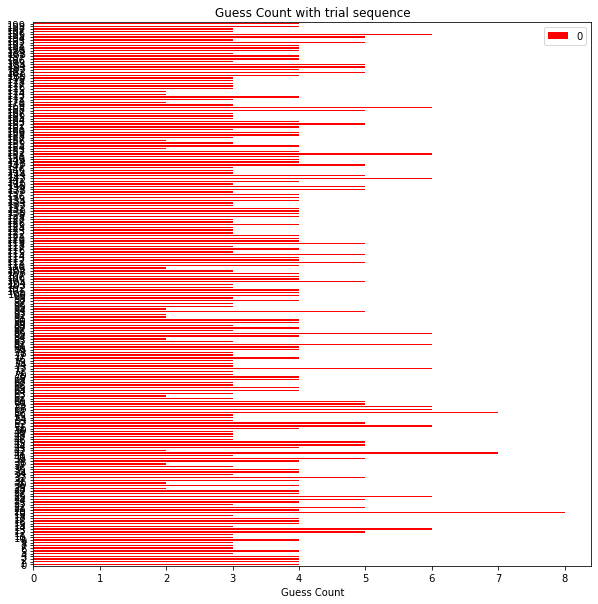

In [43]:
plt.close("all")
df = pd.DataFrame(guessCountToWin)
# fig = plt.figure(figsize=(10, 5))
# creating the bar plot
# plt.barh(df, color='maroon')
df.plot.barh(color='red', figsize=(10,10))
plt.xlabel("Guess Count")
plt.ylabel("")
plt.title("Guess Count with trial sequence")
plt.show()

In [25]:
print("Number of times we are not able to guess in 6 guess out of 200 trials, which is the limit in NY wordle game:")
print(len(list(filter(lambda x: x> 6, guessCountToWin))))

Number of times we are not able to guess in 6 guess out of 200 trials, which is the limit in NY wordle game:
3


Counter({4: 73, 3: 71, 5: 26, 2: 15, 6: 12, 7: 2, 8: 1})


<AxesSubplot:ylabel='Guess Count'>

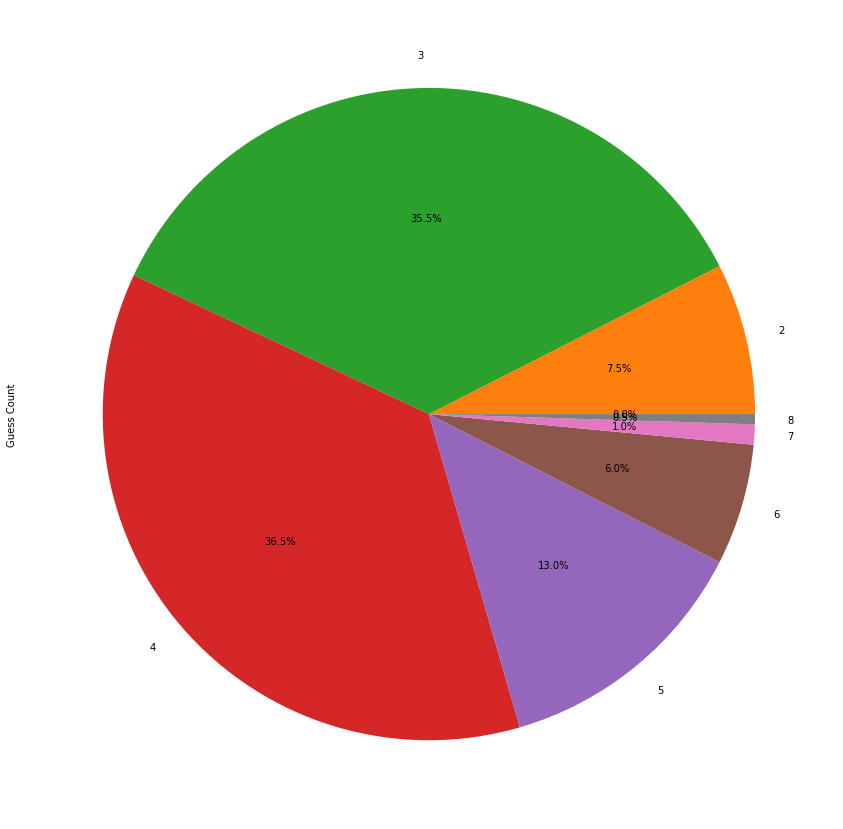

In [33]:
tryCountMap = Counter(guessCountToWin)
print(tryCountMap)
series = pd.Series(tryCountMap, index=[1,2,3,4,5,6,7,8], name="Guess Count")
series.plot.pie(autopct='%1.1f%%',figsize=(15, 15))

In [34]:
!jupyter nbconvert 2-entropy*.ipynb --to python

[NbConvertApp] Converting notebook 2-entropy-based-selection-ayushgupta.ipynb to python
[NbConvertApp] Writing 7952 bytes to 2-entropy-based-selection-ayushgupta.py
